In [79]:
import pandas as pd
import glob
import datetime as datetime
from datetime import timedelta
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import os
from scipy.integrate import quad
import sys
from scipy.optimize import leastsq
from jupyterthemes import jtplot
jtplot.reset()
import matplotlib.dates as dates
import matplotlib.dates as mdates

In [80]:
df_DWD = pd.read_csv('DWD_code_data/DWD_final_data.csv')
df_DWD['DateTime'] = pd.to_datetime(df_DWD['DateTime'])

df_IR = pd.read_csv('cloud_cover/cloud_coverage_IR_final.csv')
df_IR['DateTime'] = pd.to_datetime(df_IR['DateTime'])


df_color = pd.read_csv('cloud_cover/color_cloud_cover.csv')
df_color['DateTime']= pd.to_datetime(df_color['DateTime'])
# df_color.info()

In [81]:
# df_DWD.head()

In [82]:
# df_IR.info()
df_IR['cloud_img_round'] = df_IR['cloud_img'].apply(lambda x: round(x))
df_color['cloud_col_round'] = df_color['cloud_col'].apply(lambda x: round(x))


df_color.head()

DateTime  cloud_col  cloud_col_round
0 2020-04-15 00:00:01   0.606113                1
1 2020-04-15 00:10:08   7.990291                8
2 2020-04-15 00:20:10   7.998816                8
3 2020-04-15 00:30:12   7.999882                8
4 2020-04-15 00:40:13   0.260490                0

In [83]:
df_IR['hour'] = df_IR['DateTime'].apply(lambda x: pd.Timestamp(x).hour)
df_IR['day'] = df_IR['DateTime'].apply(lambda x: pd.Timestamp(x).day)

df_color['hour'] = df_color['DateTime'].apply(lambda x: pd.Timestamp(x).hour)
df_color['day'] = df_color['DateTime'].apply(lambda x: pd.Timestamp(x).day)


df_weather = df_DWD[(df_DWD.DateTime > '2020-04-14 23:00:00') &(df_DWD.DateTime < '2020-04-23 00:00:00')]
df_weather['hour'] = df_weather['DateTime'].apply(lambda x: pd.Timestamp(x).hour)
df_weather['day'] = df_weather['DateTime'].apply(lambda x: pd.Timestamp(x).day)


df_color['DateTime'] = df_color['DateTime']  + pd.Timedelta(hours=1)

df_color.head()

/Users/hrithikpandey/opt/anaconda3/envs/image_class/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/hrithikpandey/opt/anaconda3/envs/image_class/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


DateTime  cloud_col  cloud_col_round  hour  day
0 2020-04-15 01:00:01   0.606113                1     0   15
1 2020-04-15 01:10:08   7.990291                8     0   15
2 2020-04-15 01:20:10   7.998816                8     0   15
3 2020-04-15 01:30:12   7.999882                8     0   15
4 2020-04-15 01:40:13   0.260490                0     0   15

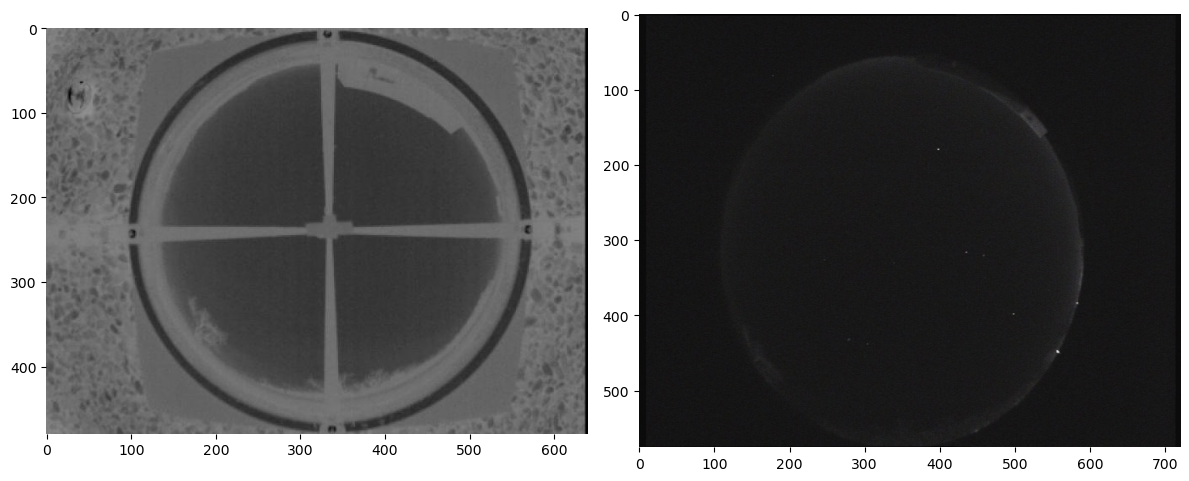

In [84]:
img_IR = cv.imread('April2020_Images/Images16_04/20200416_021550_-10+25_IrImage.jpg')
img_col = cv.flip(cv.flip(cv.imread('April2020_colorimages/Images16_04/20200416_011549_stack.jpg'),-1),0)

fig = plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.imshow(img_IR[:,:,::-1])
plt.box()
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(img_col[:,:,::-1])
plt.box()
plt.tight_layout()
plt.show()

In [85]:
df_weather[df_weather.DateTime == '2020-04-17 05:00:00']

DateTime       CWV  dwd_vis       Vis       AOD  Amb_Tem  \
14651 2020-04-17 05:00:00  1.401168     81.0  35.40548  0.098902      5.4   

       Dew_Tem  cloud  hour  day  
14651      3.7    5.0     5   17

In [86]:
T_amb = df_weather['Amb_Tem'].values
T_dew = df_weather['Dew_Tem'].values
# print(T_dew)
R_h= np.array([])
for i in range(len(T_amb)):
    r_h = 100*(np.exp((17.625*T_dew[i])/(243.04+T_dew[i]))/np.exp((17.625*T_amb[i])/(243.04+T_amb[i])))
    R_h = np.append(R_h,r_h)
#     print(T_amb[i],T_dew[i],R_h)
#     print()
# R_h[R_h < -19]


# print(df_weather.info())

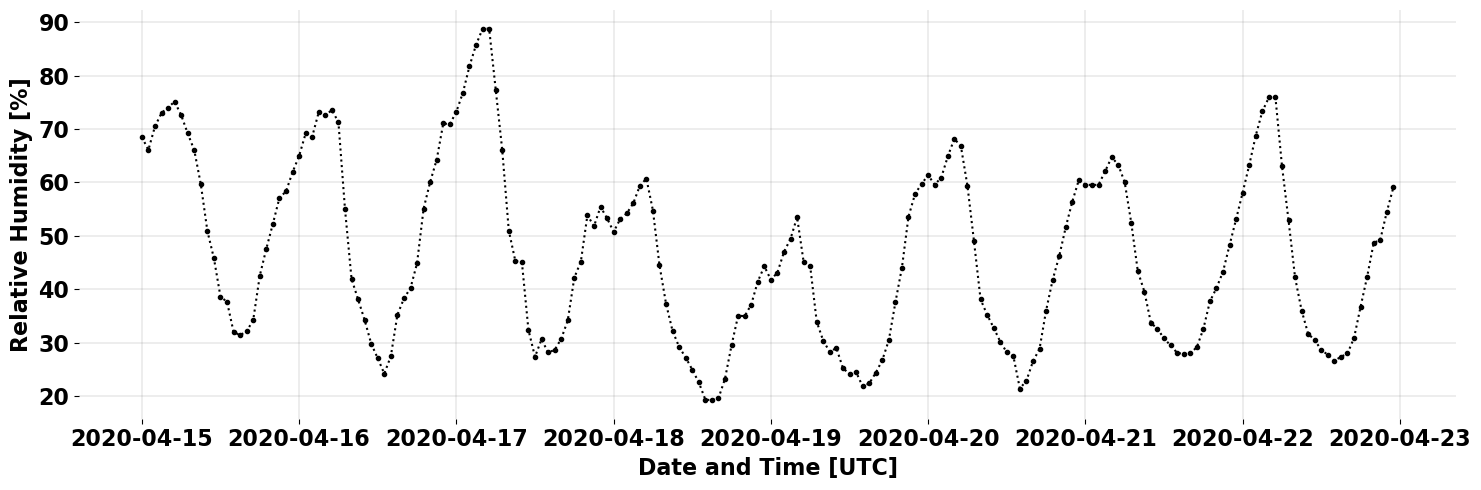

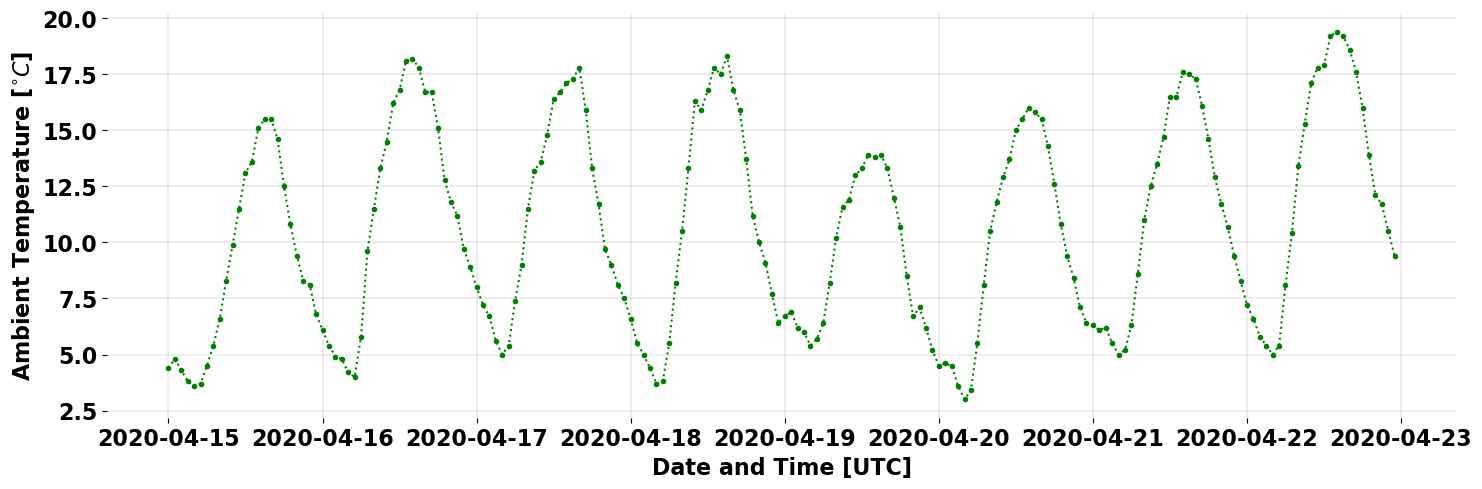

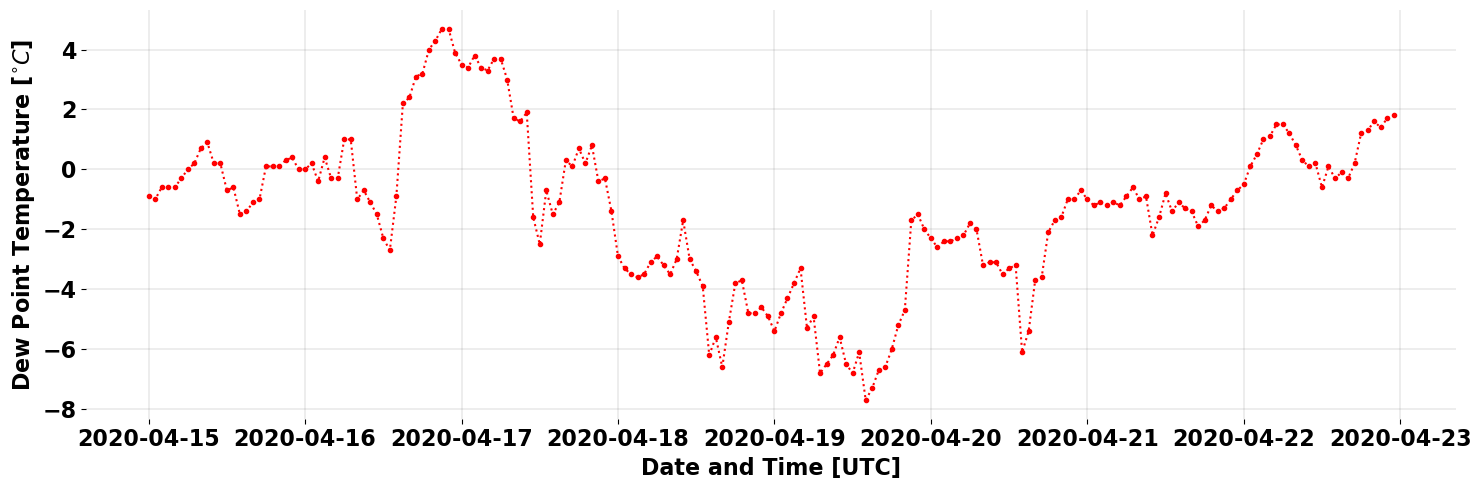

In [88]:
# fig = plt.figure(figsize = (15,15))

# plt.subplot(3,1,1)
plt.figure(figsize= (15,5))
plt.plot(df_weather['DateTime'], R_h,'k.:')

plt.xticks(fontweight = 'bold', size = 16)
plt.yticks(fontweight = 'bold', size = 16)
plt.xlabel('Date and Time [UTC]',fontweight = 'bold', size = 16)
plt.ylabel('Relative Humidity [%]',fontweight = 'bold', size = 16)
# plt.title('Relative Humidity', fontweight = 'bold', size = 16)

plt.grid(color = 'gray', linewidth = 0.2)
plt.tight_layout()
plt.box()
plt.show()

# plt.subplot(3,1,2)
plt.figure(figsize= (15,5))
plt.plot(df_weather['DateTime'], df_weather['Amb_Tem'],'g.:')

plt.xticks(fontweight = 'bold', size = 16)
plt.yticks(fontweight = 'bold', size = 16)
plt.xlabel('Date and Time [UTC]',fontweight = 'bold', size = 16)
plt.ylabel('Ambient Temperature [$^{\circ}C$]',fontweight = 'bold', size = 16)
# plt.title('Ambient Temperature', fontweight = 'bold', size = 16)

plt.grid(color = 'gray', linewidth = 0.2)
plt.tight_layout()
plt.box()
plt.show()
# plt.subplot(3,1,3)
plt.figure(figsize= (15,5))
plt.plot(df_weather['DateTime'], df_weather['Dew_Tem'],'r.:')

plt.xticks(fontweight = 'bold', size = 16)
plt.yticks(fontweight = 'bold', size = 16)
plt.xlabel('Date and Time [UTC]',fontweight = 'bold', size = 16)
plt.ylabel('Dew Point Temperature [$^{\circ}C$]',fontweight = 'bold', size = 16)
# plt.title('Dew Point Temperature', fontweight = 'bold', size = 16)

plt.grid(color = 'gray', linewidth = 0.2)
plt.tight_layout()
plt.box()
plt.show()

In [89]:
range_date = df_IR[(df_IR.DateTime > '2020-04-15 00:59:00')]
range_cloud = df_color[(df_color.DateTime < '2020-04-23')]
# df_color.tail()

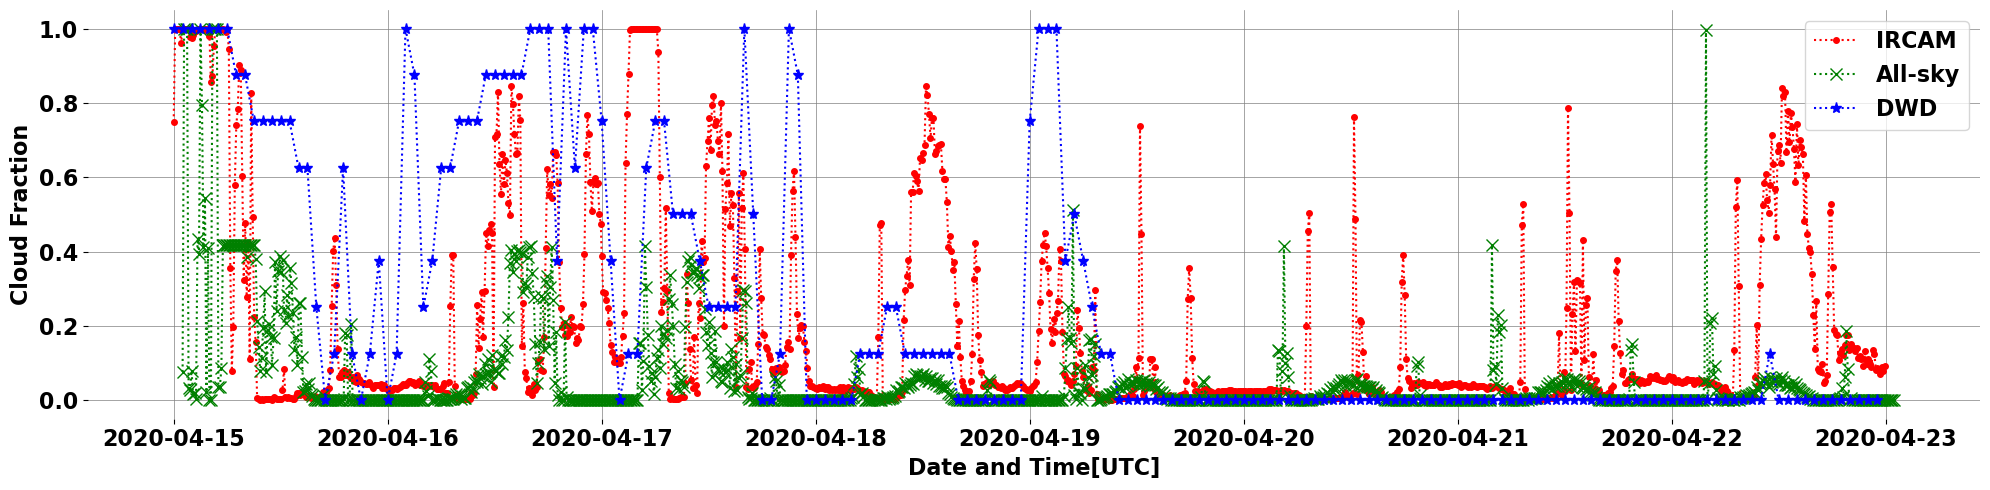

In [90]:
plt.figure(figsize = (20,5))
plt.plot(df_IR['DateTime'], df_IR['cloud_img']/8,'r.:', markersize = 8, label = 'IRCAM')
plt.plot(df_color['DateTime'], df_color['cloud_col']/8,'gx:', markersize = 8, label = 'All-sky')
# plt.plot(range_date['DateTime'], range_cloud['cloud_col']/8,'gx:', markersize = 8, label = 'All-sky')
plt.plot(df_weather['DateTime'], df_weather['cloud']/8,'b*:', markersize = 8, label = 'DWD')

# xax = plt.gca().get_xaxis()
# format major xtick label
# xax.set_major_locator(mdates.MinuteLocator(interval=200)) 
# xax.set_major_formatter(dates.DateFormatter('%d,%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(fontweight = 'bold',size = 16)

# plt.xlim(df_IR['DateTime'].iloc[0],df_IR['DateTime'].iloc[-1])

plt.legend(loc = 'best',prop={'size':16,'weight':'bold'})
plt.yticks(fontweight = 'bold',size = 16)
plt.grid(color = 'gray', linewidth = 0.5)
plt.xlabel('Date and Time[UTC]',fontweight = 'bold', size = 16)
plt.ylabel('Cloud Fraction',fontweight = 'bold', size = 16)
plt.tight_layout()
plt.box()
plt.show()

### Cloud Fraction for day and night 

In [92]:
df_color_night = df_color[(df_color.hour<= 6)|(df_color.hour >=20)]
df_IR_night = df_IR[(df_IR.hour<= 6)|(df_IR.hour >=20)]
df_weather_night = df_weather[(df_weather.hour <= 6)|(df_weather.hour >= 20)]

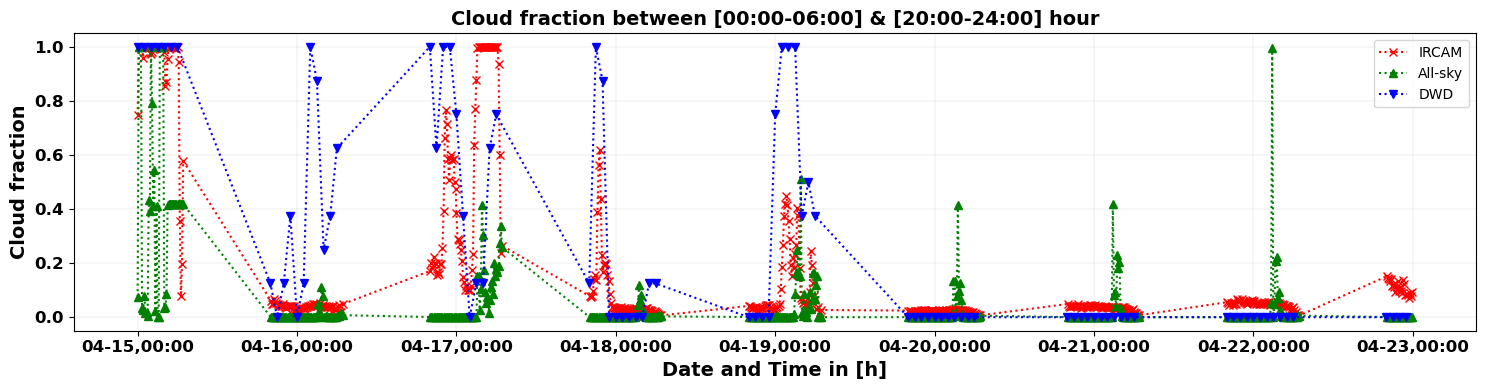

In [93]:
plt.figure(figsize = (15,4))

plt.plot(df_IR_night['DateTime'], df_IR_night['cloud_img']/8,'rx:', label = 'IRCAM')
plt.plot(df_IR_night['DateTime'], df_color_night['cloud_col']/8,'g^:', label = 'All-sky')
plt.plot(df_weather_night['DateTime'], df_weather_night['cloud']/8,'bv:', label = 'DWD')

xax = plt.gca().get_xaxis()
# format major xtick label
# xax.set_major_locator(mdates.MinuteLocator(interval=200)) 
xax.set_major_formatter(dates.DateFormatter('%m-%d,%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(fontweight = 'bold',size = 12)

# plt.xlim(df_IR['DateTime'].iloc[0],df_IR['DateTime'].iloc[-1])

plt.legend(loc = 'best')
plt.yticks(fontweight = 'bold',size = 12)
plt.grid(color = 'gray', linewidth = 0.1)
plt.xlabel('Date and Time in [h]',fontweight = 'bold', size = 14)
plt.ylabel('Cloud fraction',fontweight = 'bold', size = 14)
plt.title('Cloud fraction between [00:00-06:00] & [20:00-24:00] hour',fontweight = 'bold', size = 14)
plt.tight_layout()
plt.show()

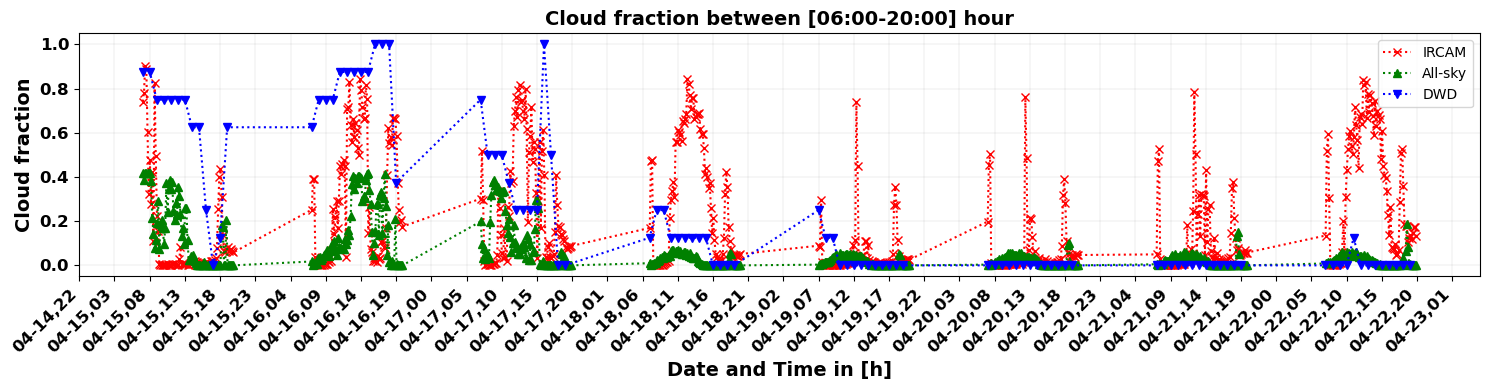

In [94]:
from matplotlib.dates import HourLocator, DayLocator, DateFormatter
hours = mdates.HourLocator(interval = 5)  #
h_fmt = mdates.DateFormatter('%m-%d,%H')


df_color_day = df_color[(df_color.hour> 6)&(df_color.hour <20)]
df_IR_day = df_IR[(df_IR.hour> 6)&(df_IR.hour <20)]
df_weather_day = df_weather[(df_weather.hour> 6)&(df_weather.hour <20)]

fig, ax = plt.subplots(figsize = (15,4))

plt.plot(df_IR_day['DateTime'], df_IR_day['cloud_img']/8,'rx:', label = 'IRCAM')
plt.plot(df_IR_day['DateTime'], df_color_day['cloud_col']/8,'g^:', label = 'All-sky')
plt.plot(df_weather_day['DateTime'], df_weather_day['cloud']/8,'bv:', label = 'DWD')


# format major xtick label
# ax.set_major_locator(hours) 
# ax.set_major_formatter(dates.DateFormatter('%m-%d,%H'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator())

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.xticks(fontweight = 'bold',rotation = 45,size = 12,ha = 'right')

# plt.xlim(df_IR_day['DateTime'].iloc[0],df_IR_day['DateTime'].iloc[-1])

plt.legend(loc = 'best')
# plt.xticks(fontweight = 'bold',size = 12)
plt.yticks(fontweight = 'bold',size = 12)
plt.grid(color = 'gray', linewidth = 0.1)
plt.xlabel('Date and Time in [h]',fontweight = 'bold', size = 14)
plt.ylabel('Cloud fraction',fontweight = 'bold', size = 14)
plt.title('Cloud fraction between [06:00-20:00] hour',fontweight = 'bold', size = 14)
plt.tight_layout()
plt.show()

#### Residual comparison: 

1. IRCAM and Allsky cam:

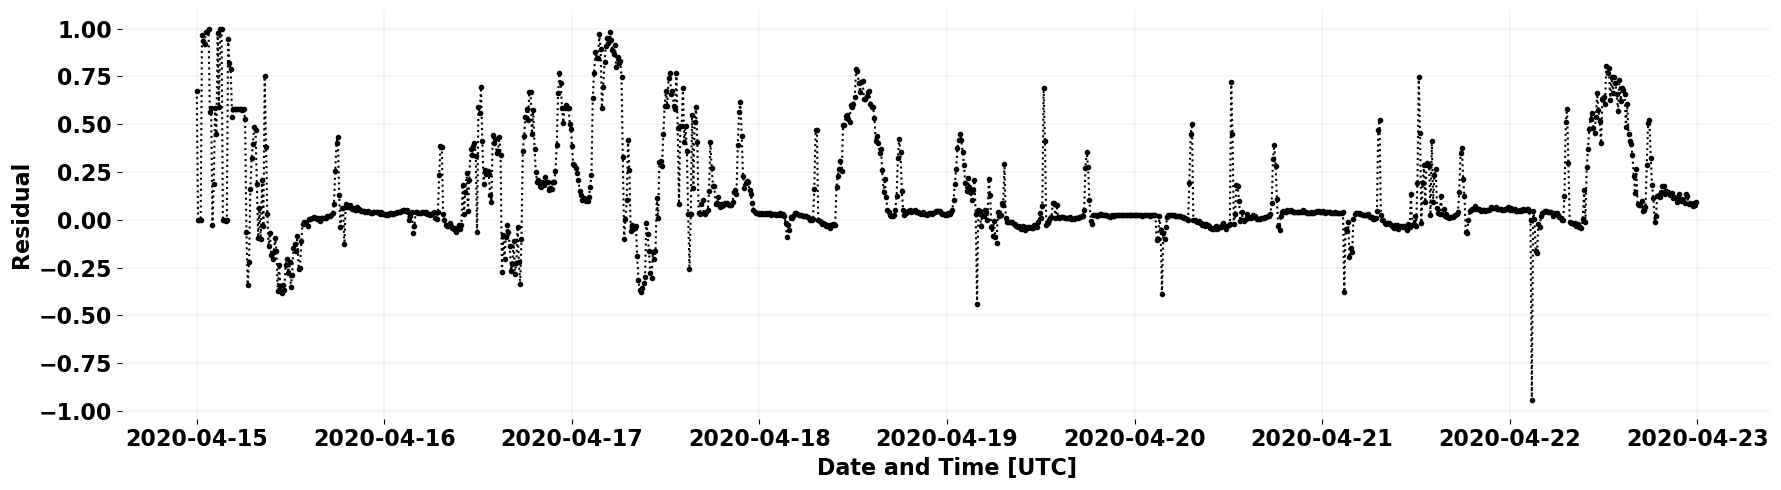

In [97]:
error = df_IR['cloud_img']/8 - df_color['cloud_col']/8


plt.figure(figsize = (18,5))
plt.plot(df_IR['DateTime'], error,'k.:')

# xax = plt.gca().get_xaxis()
# format major xtick label
# xax.set_major_locator(mdates.MinuteLocator(interval=200)) 
# xax.set_major_formatter(dates.DateFormatter('%d,%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(fontweight = 'bold',size = 16)


# plt.xlim(df_IR['DateTime'].iloc[0],df_IR['DateTime'].iloc[-1])

plt.yticks(fontweight = 'bold',size = 16)
plt.grid(color = 'gray', linewidth = 0.1)
plt.xlabel('Date and Time [UTC]',fontweight = 'bold', size = 16)
plt.ylabel('Residual',fontweight = 'bold', size = 16)
# plt.title('IRCAM - All-sky residual',fontweight = 'bold', size = 14)
plt.tight_layout()
plt.box()
plt.show()



528
528
528


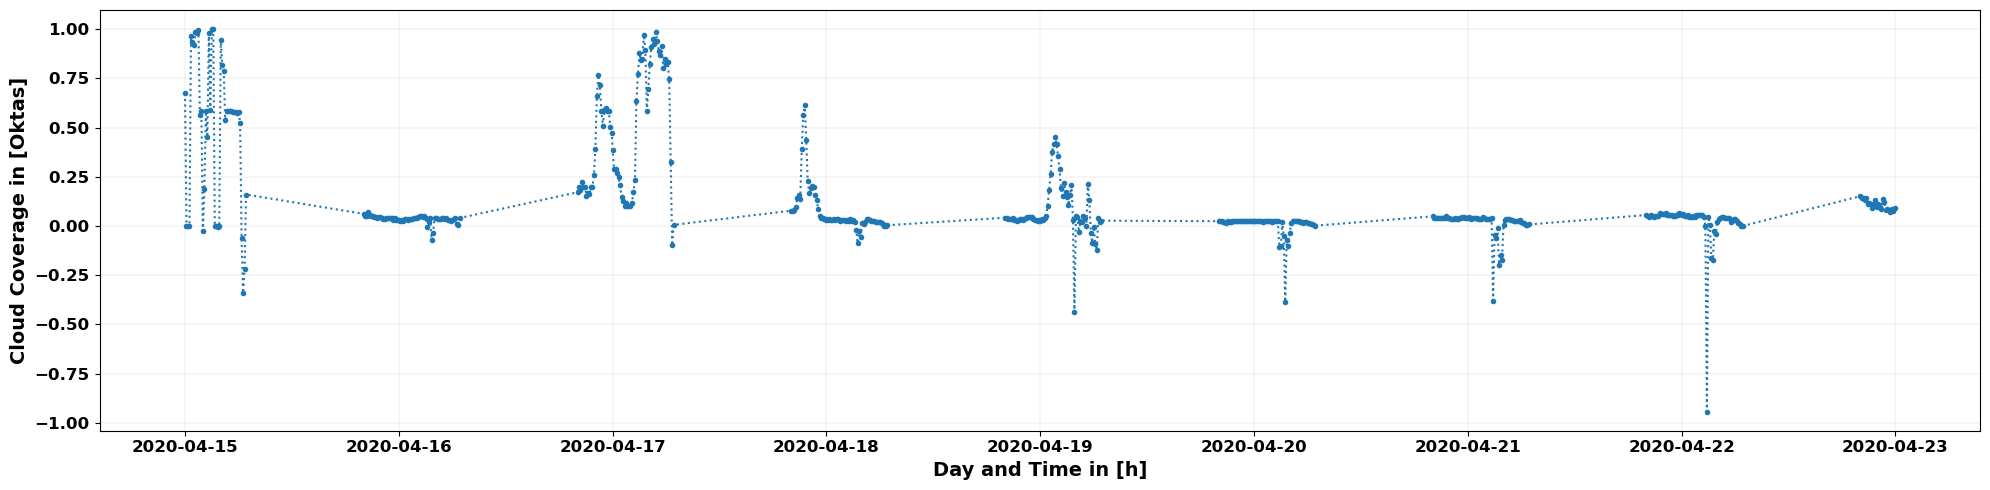

In [98]:
# night_time redsidual estimation 
df_color_night = df_color[(df_color.hour<= 6)|(df_color.hour >=20)]
df_IR_night = df_IR[(df_IR.hour<= 6)|(df_IR.hour >=20)]
print(len(df_IR_night))
print(len(df_color_night))

err_night=  df_IR_night['cloud_img'].values/8 - df_color_night['cloud_col'].values/8

print(len(err_night))

plt.figure(figsize = (20,5))
plt.plot(df_IR_night['DateTime'], err_night,'.:')

# xax = plt.gca().get_xaxis()
# # format major xtick label
# xax.set_major_locator(mdates.MinuteLocator(interval=200)) 
# xax.set_major_formatter(dates.DateFormatter('%d,%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(fontweight = 'bold',size = 12)

# plt.xlim(df_IR_night['DateTime'].iloc[0],df_IR_night['DateTime'].iloc[-1])

plt.yticks(fontweight = 'bold',size = 12)
plt.grid(color = 'gray', linewidth = 0.1)
plt.xlabel('Day and Time in [h]',fontweight = 'bold', size = 14)
plt.ylabel('Cloud Coverage in [Oktas]',fontweight = 'bold', size = 14)
plt.tight_layout()
plt.show()

-0.1 - 0.1 : 70.83333333333334
-0.2 - 0.2 : 81.81818181818183
-0.3 - 0.3 : 84.84848484848484
Median: 0.04043882643685499
5th Percentile: -0.03919962146390052
95th Percentile: 0.26463218505165786


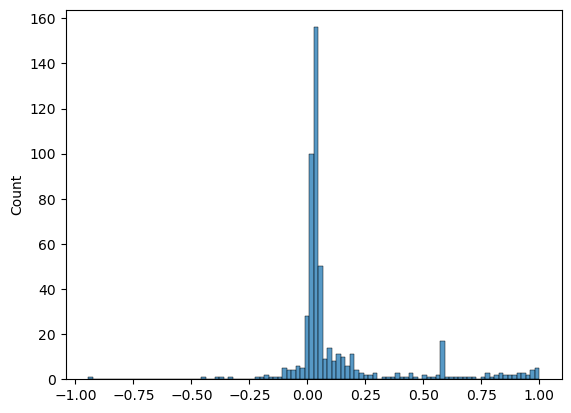

In [99]:
import seaborn as sns

range_1 = len(err_night[(err_night >=-0.1) & (err_night <=0.1) ])/len(err_night)*100
print('-0.1 - 0.1 :',range_1)
range_2 = len(err_night[(err_night >=-0.2) & (err_night <=0.2) ])/len(err_night)*100
print('-0.2 - 0.2 :',range_2)
range_3 = len(err_night[(err_night >=-0.3) & (err_night <=0.3) ])/len(err_night)*100
print('-0.3 - 0.3 :',range_3)
print('Median:',np.median(err_night))
print('5th Percentile:',np.percentile(err_night,5))
print('95th Percentile:',np.percentile(err_night,85))

sns.histplot(err_night,bins = 100)
plt.show()




624


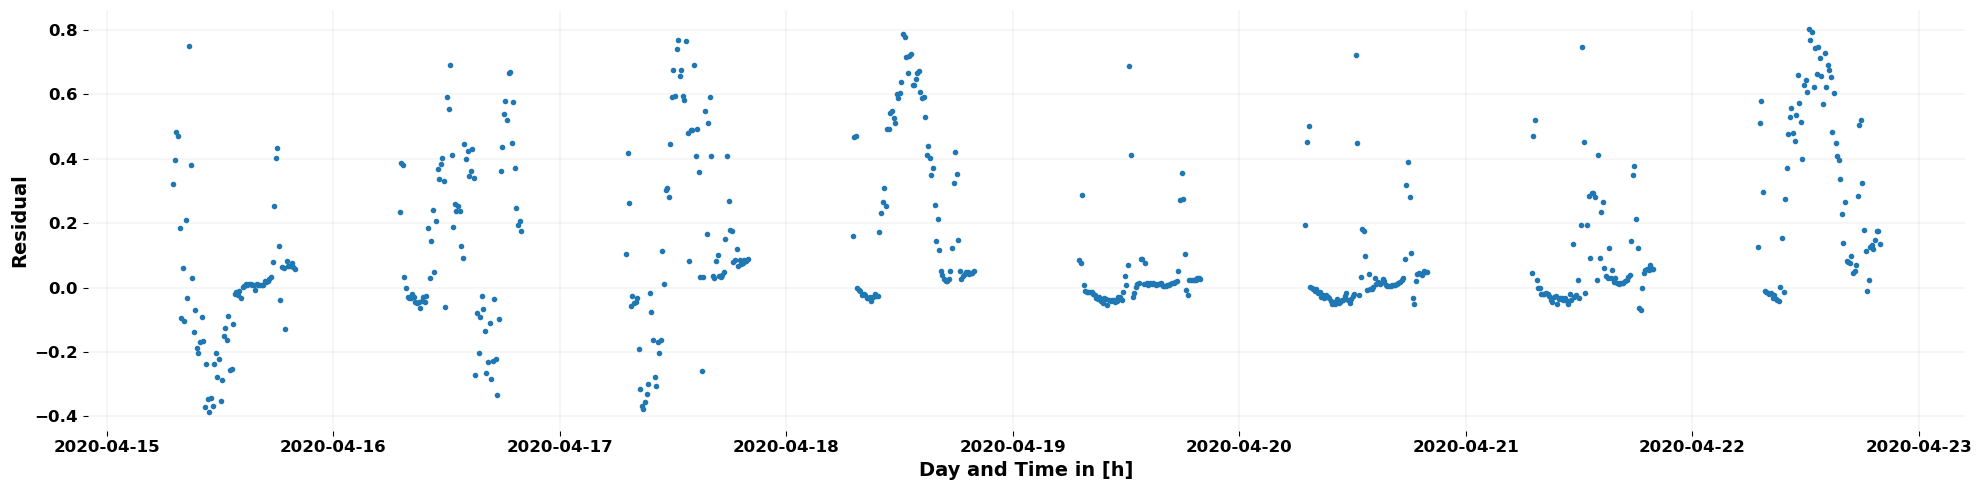

In [100]:
# daytime 
# night_time redsidual estimation 
df_color_day = df_color[(df_color.hour> 6)&(df_color.hour <20)]
df_IR_day = df_IR[(df_IR.hour> 6)&(df_IR.hour <20)]

err_day= df_IR_day['cloud_img'].values/8 - df_color_day['cloud_col'].values/8

print(len(err_day))

plt.figure(figsize = (20,5))
plt.plot(df_IR_day['DateTime'], err_day,'.', label = 'IRCAM-All-sky')

plt.xticks(fontweight = 'bold',size = 12)
plt.yticks(fontweight = 'bold',size = 12)
plt.grid(color = 'gray', linewidth = 0.1)
plt.xlabel('Day and Time in [h]',fontweight = 'bold', size = 14)
plt.ylabel('Residual',fontweight = 'bold', size = 14)
plt.title('')
plt.tight_layout()
plt.box()
plt.show()

-0.1 - 0.1 : 54.64743589743589
-0.2 - 0.2 : 64.42307692307693
-0.3 - 0.3 : 73.07692307692307
Median: 0.034573793586987284
5th Percentile: -0.20326631107007323
95th Percentile: 0.6602163314837359


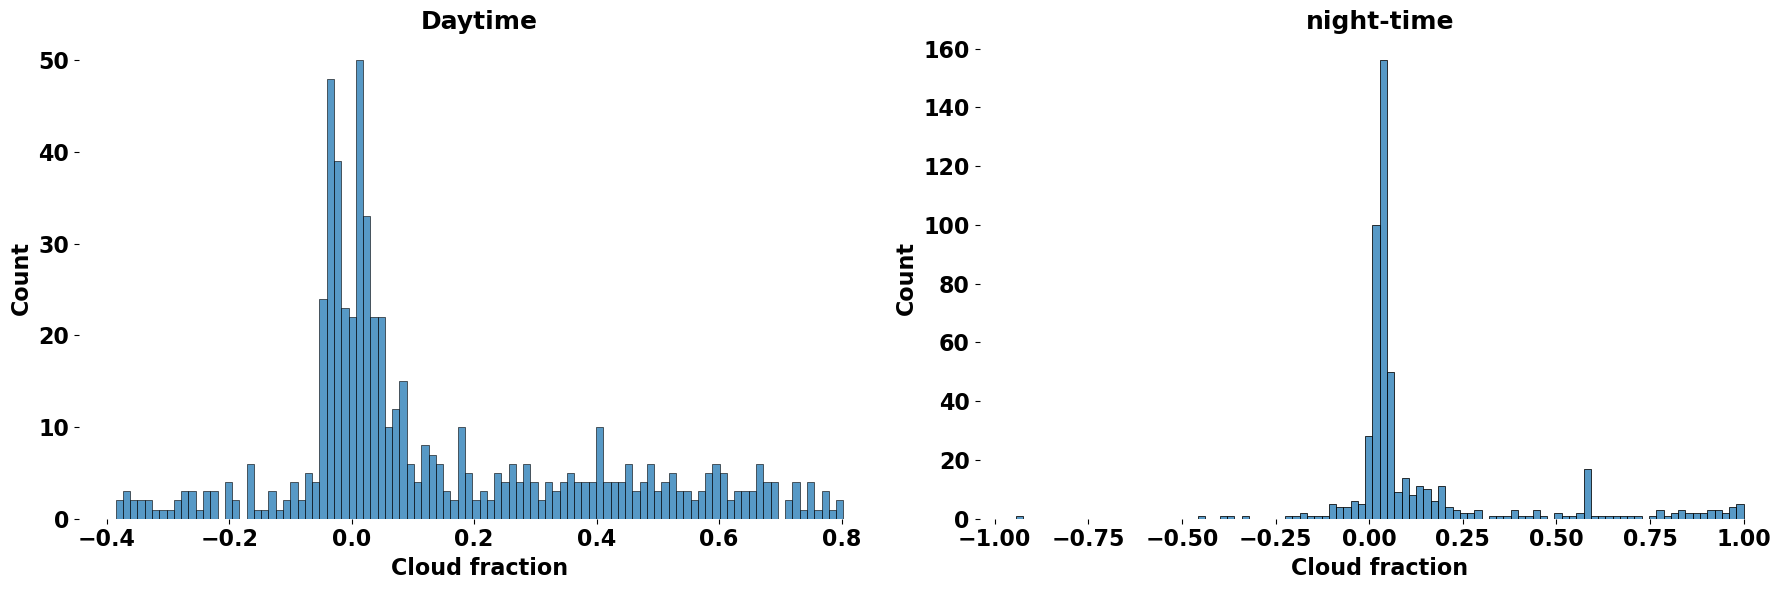

In [105]:
range_1 = len(err_day[(err_day >=-0.1) & (err_day <=0.1) ])/len(err_day)*100
print('-0.1 - 0.1 :',range_1)
range_2 = len(err_day[(err_day >=-0.2) & (err_day <=0.2) ])/len(err_day)*100
print('-0.2 - 0.2 :',range_2)
range_3 = len(err_day[(err_day >=-0.3) & (err_day <=0.3) ])/len(err_day)*100
print('-0.3 - 0.3 :',range_3)
print('Median:',np.median(err_day))
print('5th Percentile:',np.percentile(err_day,5))
print('95th Percentile:',np.percentile(err_day,95))

fig = plt.figure(figsize = (18,6))

plt.subplot(1,2,1)
sns.histplot(err_day,bins = 100)
plt.title('Daytime', fontweight = 'bold', size = 18)
plt.xlabel('Cloud fraction',fontweight = 'bold', size = 16)
plt.ylabel('Count',fontweight = 'bold', size = 16)
plt.xticks(fontweight = 'bold', size = 16)
plt.yticks(fontweight = 'bold', size = 16)
plt.box()
plt.tight_layout()

plt.subplot(1,2,2)
sns.histplot(err_night,bins = 100)
plt.title('night-time', fontweight = 'bold', size = 18)
plt.xlabel('Cloud fraction',fontweight = 'bold', size = 16)
plt.ylabel('Count',fontweight = 'bold', size = 16)
plt.xticks(fontweight = 'bold', size = 16)
plt.yticks(fontweight = 'bold', size = 16)
plt.box()
plt.tight_layout()
plt.show()

In [106]:
# 
# range +-1 

range_1 = len(err_day[(err_day >=-0.1) & (err_day <=0.1) ])/len(err_day)*100
print(range_1)
range_2 = len(err_day[(err_day >=-0.2) & (err_day <=0.2) ])/len(err_day)*100
print(range_2)

54.64743589743589
64.42307692307693


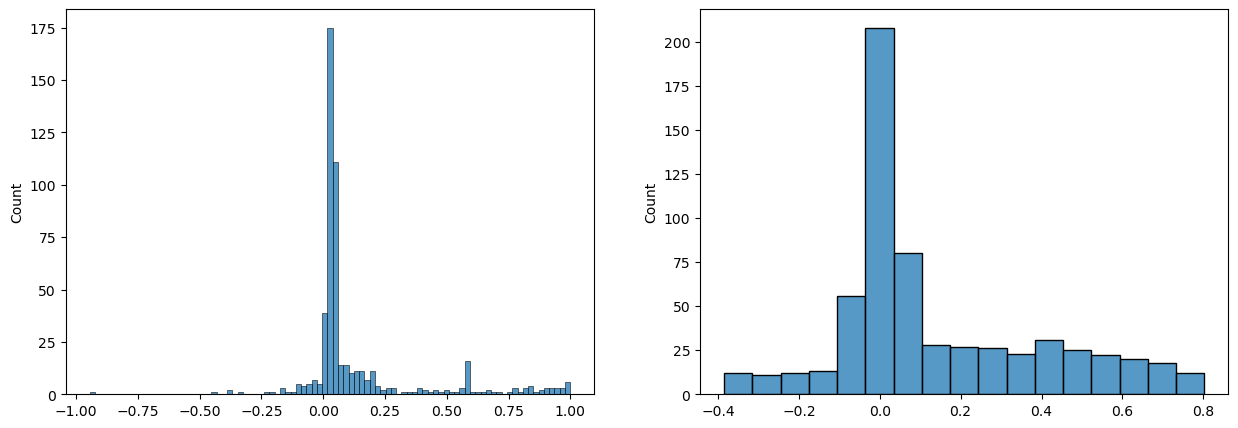

In [107]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(err_night)
# plt.show()
plt.subplot(1,2,2)
sns.histplot(err_day)
plt.show()

In [495]:
np.mean(err_day)

-0.13811156784709117

### convert IR and Allsky data to hourly basis

In [108]:
def convert_to_hourly(mean_hour):
    time = []
    for i in mean_hour.index:
    #     print(i[0])
        t = datetime.datetime.strptime('2020-04-'+str(i[0])+' '+str(i[1]), '%Y-%m-%d %H')
        time.append(t)

#     err_IR_DWD = mean_hour.values- df_weather['cloud'].values
    mean_IR_hour = np.vstack((time,mean_hour.values)).T
#     print(np.shape(mean_IR_hour))
    return(mean_IR_hour)

df_IR_mean = df_IR.groupby(['day','hour'])['cloud_img'].mean()
df_color_mean = df_color.groupby(['day','hour'])['cloud_col'].mean()
# print(df_color.info())

In [109]:
mean_IR_hour = convert_to_hourly(df_IR_mean)
mean_color_hour = convert_to_hourly(df_color_mean)

In [110]:
df_IR_hourly = pd.DataFrame({'DateTime':mean_IR_hour[:,0], 'cloud_fraction':mean_IR_hour[:,1]/8})
df_color_hourly = pd.DataFrame({'DateTime':mean_color_hour[:,0], 'cloud_fraction':mean_color_hour[:,1]/8})

# df_IR_hourly.to_csv('cloud_cover/IR_hourly.csv', header = True, index = False)

In [111]:
#  %age data with error between [-2:+2]
per_ = (err_IR_DWD[(err_IR_DWD <= 2) & (err_IR_DWD >= -2)])

NameError: name 'err_IR_DWD' is not defined

In [112]:
def relative_frequency(lst, element):
    return lst.count(element) / float(len(lst))

IR_cloud = df_IR['cloud_img_round'].to_list()
allsky_cloud = df_color['cloud_col_round'].to_list()
dwd_cloud = df_weather['cloud'].to_list()

counts_IR = np.array([(word, IR_cloud.count(word)*100 / len(IR_cloud))for word in set(IR_cloud)] )
counts_col = np.array([(word, allsky_cloud.count(word)*100 / len(allsky_cloud)) for word in set(allsky_cloud)] )
counts_dwd = np.array([(word, dwd_cloud.count(word)*100 / len(dwd_cloud)) for word in set(dwd_cloud)]) 

/Users/hrithikpandey/opt/anaconda3/envs/image_class/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


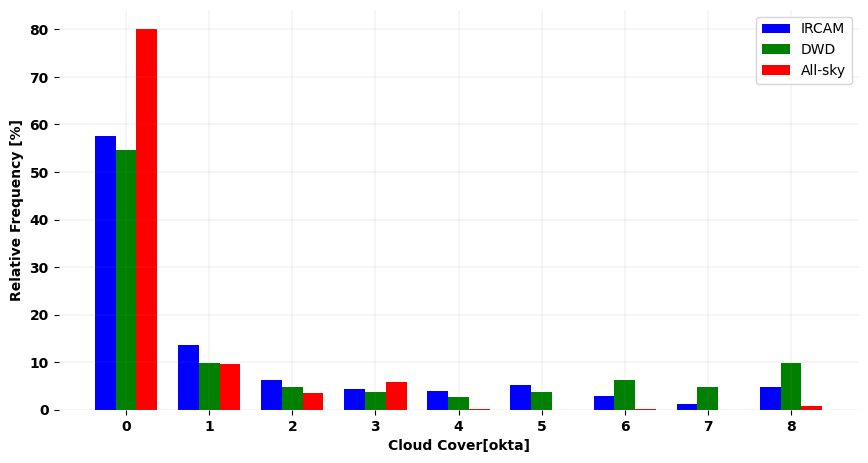

In [113]:
X = counts_IR[:,0]

fig = plt.figure(figsize= (8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(counts_IR[:,0] - 0.25, counts_IR[:,1], color = 'b', width = 0.25, label = 'IRCAM')
ax.bar(counts_dwd[:,0] + 0.00, counts_dwd[:,1], color = 'g', width = 0.25,label ='DWD' )
ax.bar(counts_col[:,0] + 0.25, counts_col[:,1], color = 'r', width = 0.25,label = 'All-sky')

plt.legend(loc='best')
plt.xticks(np.arange(0,9,1),fontweight= 'bold')
plt.xlabel('Cloud Cover[okta]',fontweight= 'bold')
plt.ylabel('Relative Frequency [%]',fontweight= 'bold')
plt.yticks(fontweight= 'bold')
plt.grid(color = 'gray', linewidth = 0.1)
plt.tight_layout()
plt.box()
plt.show()

In [114]:
### Segregation based on night-time:
night_IR = df_IR[(df_IR.hour <= 6) | (df_IR.hour >= 20)]
night_DWD = df_weather[(df_weather.hour <= 6) | (df_weather.hour >= 20)]
print(len(night_DWD),len(night_IR))

mean_hour_night = night_IR.groupby(['day','hour'])['cloud_img'].mean()
print(len(mean_hour_night))
time_night = []
for i in mean_hour_night.index:
#     print(i[0])
    t = datetime.datetime.strptime('2020-04-'+str(i[0])+' '+str(i[1]), '%Y-%m-%d %H')
    time_night.append(t)
    
err_IR_DWD_night = mean_hour_night.values- night_DWD['cloud'].values
print(len(err_IR_DWD_night))
mean_IR_hour_night = np.vstack((time_night,mean_hour_night.values, err_IR_DWD_night)).T
print(mean_IR_hour_night.shape)

88 528
88
88
(88, 3)


In [115]:
median_night = np.median(mean_IR_hour_night[:,2]/8)
print(median_night)
per5 = np.percentile(mean_IR_hour_night[:,2]/8,5)
per95 = np.percentile(mean_IR_hour_night[:,2]/8,95)
print('Night Time:  ')
print('   Median                  5th Percentile            95th Percentile:\n',median_night,'  ', per5,'  ',per95  )

0.024534033078880406
Night Time:  
   Median                  5th Percentile            95th Percentile:
 0.024534033078880406    -0.728915473918575    0.12771596692111936


In [116]:
## All-sky camera result evaluation

### Segregation based on night-time:/
night_IR = df_IR[(df_IR.hour <= 6) | (df_IR.hour >= 20)]
night_DWD = df_weather[(df_weather.hour <= 6) | (df_weather.hour >= 20)]
night_color = df_color[(df_color.hour <= 6) | (df_color.hour >= 20)]
# night_DWD = df_weather[(df_weather.hour <= 6) | (df_weather.hour >= 20)]
print(len(night_DWD),len(night_color))
# print(night_IR)

mean_hour_night_col = night_color.groupby(['day','hour'])['cloud_col'].mean()
print(len(mean_hour_night_col))
time_night_col = []
for i in mean_hour_night_col.index:
#     print(i[0])
    t = datetime.datetime.strptime('2020-04-'+str(i[0])+' '+str(i[1]), '%Y-%m-%d %H')
    time_night_col.append(t)
    
err_col_DWD_night = mean_hour_night_col.values- night_DWD['cloud'].values
print(len(err_col_DWD_night))
mean_col_hour_night = np.vstack((time_night_col,mean_hour_night_col.values, err_col_DWD_night)).T
print(mean_col_hour_night.shape)

88 528
88
88
(88, 3)


#### Relative Frequency for night time data

In [117]:
df_IR_mean_night = night_IR.groupby(['day','hour'])['cloud_img_round'].mean()
df_color_mean_night = night_color.groupby(['day','hour'])['cloud_col_round'].mean()

mean_IR_hour_night = convert_to_hourly(df_IR_mean_night)
mean_color_hour_night = convert_to_hourly(df_color_mean_night)
# np.round(mean_IR_hour, 1)


/Users/hrithikpandey/opt/anaconda3/envs/image_class/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


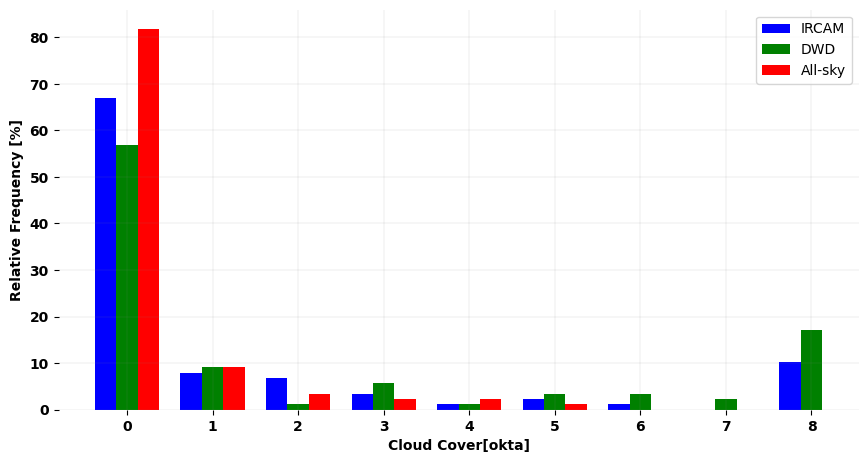

In [118]:
night_IR_ =np.round(np.float64(mean_IR_hour_night[:,1])).tolist()
night_allsky_ =np.round(np.float64(mean_color_hour_night[:,1])).tolist()
night_DWD_ = night_DWD['cloud'].to_list()


night_counts_IR = np.array([(word, night_IR_.count(word)*100 / len(night_IR_))for word in set(night_IR_)] )
night_counts_col = np.array([(word, night_allsky_.count(word)*100 / len(night_allsky_)) for word in set(night_allsky_)] )
night_counts_dwd = np.array([(word, night_DWD_.count(word)*100 / len(night_DWD_)) for word in set(night_DWD_)]) 


# print(night_counts_IR[:,0])

fig = plt.figure(figsize= (8,4))

ax = fig.add_axes([0,0,1,1])
ax.bar(night_counts_IR[:,0] - 0.25, night_counts_IR[:,1], color = 'b', width = 0.25, label = 'IRCAM')
ax.bar(night_counts_dwd[:,0] + 0.00, night_counts_dwd[:,1], color = 'g', width = 0.25,label ='DWD' )
ax.bar(night_counts_col[:,0] + 0.25, night_counts_col[:,1], color = 'r', width = 0.25,label = 'All-sky')

plt.legend(loc='best')
plt.xticks(np.arange(0,9,1),fontweight= 'bold')
plt.xlabel('Cloud Cover[okta]',fontweight= 'bold')
plt.ylabel('Relative Frequency [%]',fontweight= 'bold')
plt.yticks(fontweight= 'bold')
plt.grid(color = 'gray', linewidth = 0.1)
plt.tight_layout()
plt.box()
plt.show()

#### Relative frequency for daytime 

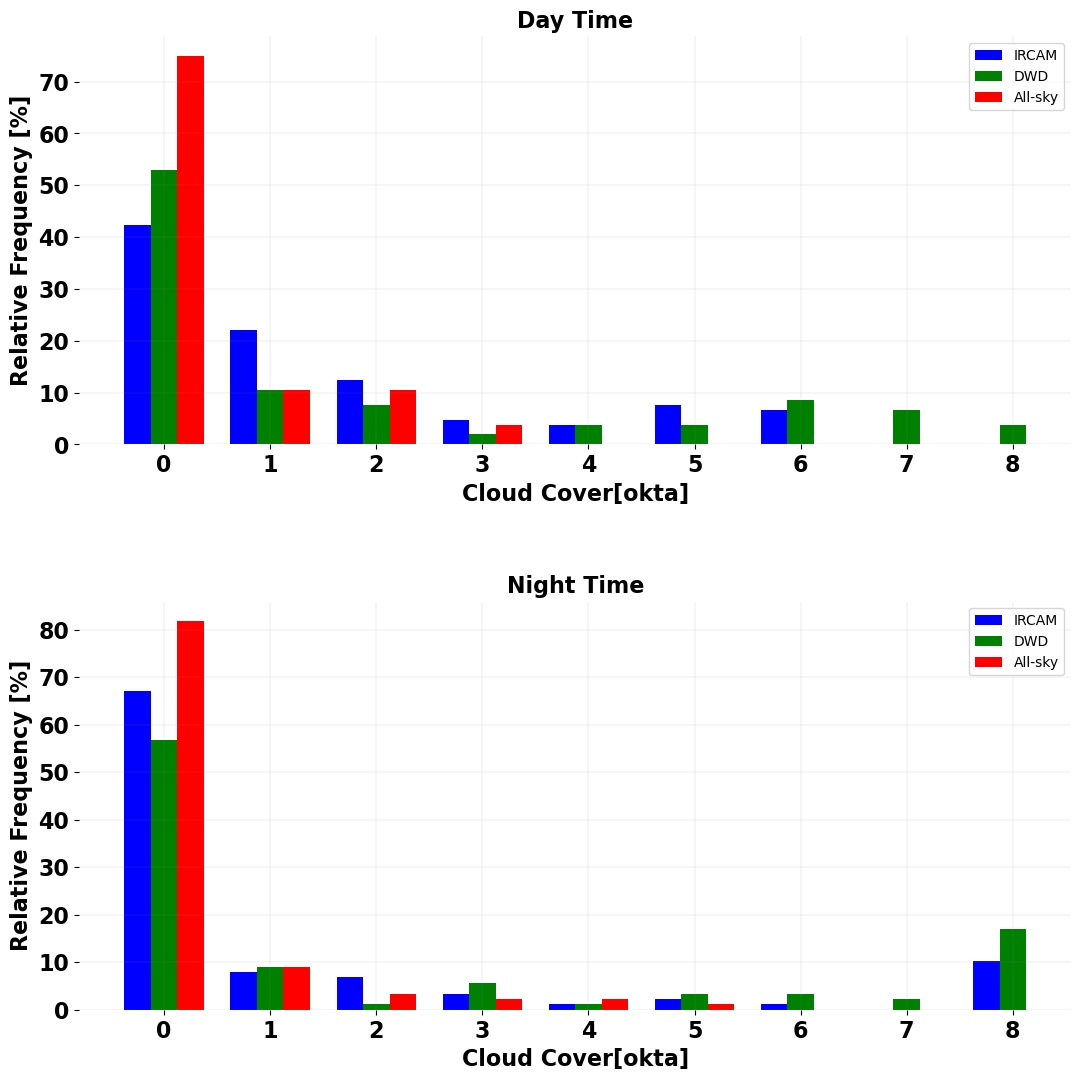

In [119]:
day_IR = df_IR[(df_IR.hour > 6) & (df_IR.hour < 20)]
day_color = df_color[(df_color.hour > 6) & (df_color.hour < 20)]
day_DWD = df_weather[(df_weather.hour > 6) & (df_weather.hour < 20)]

df_IR_mean_day = day_IR.groupby(['day','hour'])['cloud_img_round'].mean()
df_color_mean_day = day_color.groupby(['day','hour'])['cloud_col_round'].mean()

mean_IR_hour_day = convert_to_hourly(df_IR_mean_day)
mean_color_hour_day = convert_to_hourly(df_color_mean_day)

day_IR_ =np.round(np.float64(mean_IR_hour_day[:,1])).tolist()
day_allsky_ =np.round(np.float64(mean_color_hour_day[:,1])).tolist()
day_DWD_ = day_DWD['cloud'].to_list()

day_counts_IR = np.array([(word, day_IR_.count(word)*100 / len(day_IR_))for word in set(day_IR_)] )
day_counts_col = np.array([(word, day_allsky_.count(word)*100 / len(day_allsky_)) for word in set(day_allsky_)] )
day_counts_dwd = np.array([(word, day_DWD_.count(word)*100 / len(day_DWD_)) for word in set(day_DWD_)]) 




fig = plt.figure(figsize= (12,12))

plt.subplot(2,1,1)
# ax1 = fig.add_axes([0,0,1,1])
plt.bar(day_counts_IR[:,0] - 0.25, day_counts_IR[:,1], color = 'b', width = 0.25, label = 'IRCAM')
plt.bar(day_counts_dwd[:,0] + 0.00, day_counts_dwd[:,1], color = 'g', width = 0.25,label ='DWD' )
plt.bar(day_counts_col[:,0] + 0.25, day_counts_col[:,1], color = 'r', width = 0.25,label = 'All-sky')

plt.legend(loc='best')
plt.xticks(np.arange(0,9,1),fontweight= 'bold',size = 16)
plt.xlabel('Cloud Cover[okta]',fontweight= 'bold',size = 16)
plt.ylabel('Relative Frequency [%]',fontweight= 'bold',size = 16)
plt.yticks(fontweight= 'bold',size = 16)
plt.title('Day Time',fontweight= 'bold',size = 16)
plt.grid(color = 'gray', linewidth = 0.1)
plt.tight_layout()
plt.box()
# plt.show()

plt.subplot(2,1,2)

plt.bar(night_counts_IR[:,0] - 0.25, night_counts_IR[:,1], color = 'b', width = 0.25, label = 'IRCAM')
plt.bar(night_counts_dwd[:,0] + 0.00, night_counts_dwd[:,1], color = 'g', width = 0.25,label ='DWD' )
plt.bar(night_counts_col[:,0] + 0.25, night_counts_col[:,1], color = 'r', width = 0.25,label = 'All-sky')

plt.legend(loc='best')
plt.xticks(np.arange(0,9,1),fontweight= 'bold',size = 16)
plt.xlabel('Cloud Cover[okta]',fontweight= 'bold',size = 16)
plt.ylabel('Relative Frequency [%]',fontweight= 'bold',size = 16)
plt.yticks(fontweight= 'bold',size = 16)
plt.title('Night Time',fontweight= 'bold',size = 16)
plt.grid(color = 'gray', linewidth = 0.1)
plt.tight_layout()
plt.box()

fig.tight_layout(pad = 5.0)

plt.show()

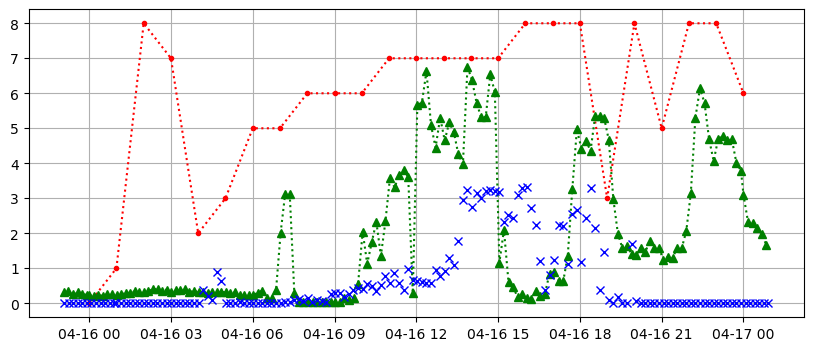

In [120]:
# day_IR
df_16_dwd = df_weather[(df_weather.DateTime> '2020-04-15 23:00:00') & (df_weather.DateTime< '2020-04-17 01:00:00')]
df_16_ir = df_IR[(df_IR.DateTime> '2020-04-15 23:00:00') & (df_IR.DateTime< '2020-04-17 01:00:00')]
df_16_col = df_color[(df_color.DateTime> '2020-04-15 23:00:00') & (df_color.DateTime< '2020-04-17 01:00:00')]

fig = plt.figure(figsize= (10,4))

# plt.subplot(3,1,1)
# plt.plot(df_16_dwd['DateTime'], df_16_dwd['Amb_Tem'],'.:')
# plt.grid()
# # plt.show()

# plt.subplot(3,1,2)
# plt.plot(df_16_dwd['DateTime'], df_16_dwd['CWV'],'.:')
# plt.grid()
# plt.show()

# plt.subplot(3,1,3)
plt.plot(df_16_dwd['DateTime'], df_16_dwd['cloud'],'r.:')
plt.plot(df_16_ir['DateTime'], df_16_ir['cloud_img'],'g^:')
plt.plot(df_16_col['DateTime'], df_16_col['cloud_col'],'bx')
plt.grid()
plt.show()

#### Hourly data 

In [122]:
df_IR_hourly = pd.read_csv('cloud_cover/IR_hourly.csv')
df_IR_hourly['DateTime'] = pd.to_datetime(df_IR_hourly['DateTime'] )

df_color_hourly = pd.read_csv('cloud_cover/color_hourly.csv')
df_color_hourly['DateTime'] = pd.to_datetime(df_color_hourly['DateTime'] )


In [123]:
df_IR_hourly['hour'] = df_IR_hourly['DateTime'].apply(lambda x: pd.Timestamp(x).hour)
df_IR_hourly['day'] = df_IR_hourly['DateTime'].apply(lambda x: pd.Timestamp(x).day)

df_color_hourly['hour'] = df_color_hourly['DateTime'].apply(lambda x: pd.Timestamp(x).hour)
df_color_hourly['day'] = df_color_hourly['DateTime'].apply(lambda x: pd.Timestamp(x).day)


In [124]:
df_IR_hourly_day = df_IR_hourly[(df_IR_hourly.hour >= 6 ) & (df_IR_hourly.hour <= 20 )]
df_weather_day = df_weather[(df_weather.hour >= 6 ) & (df_weather.hour <= 20 )]
# df_weather_day

err_ir_dwd_day = df_IR_hourly_day['cloud_fraction'].values/8 - df_weather_day['cloud'].values/8

In [125]:
df_IR_hourly_night = df_IR_hourly[(df_IR_hourly.hour < 6 ) | (df_IR_hourly.hour > 20 )]
df_weather_night = df_weather[(df_weather.hour < 6 ) | (df_weather.hour > 20 )]
# df_weather_day

err_ir_dwd_night = df_IR_hourly_night['cloud_fraction'].values/8 - df_weather_night['cloud'].values/8

In [126]:
# IRCAM vs DWD

err_ir_dwd = df_IR_hourly['cloud_fraction'].values - df_weather['cloud'].values/8

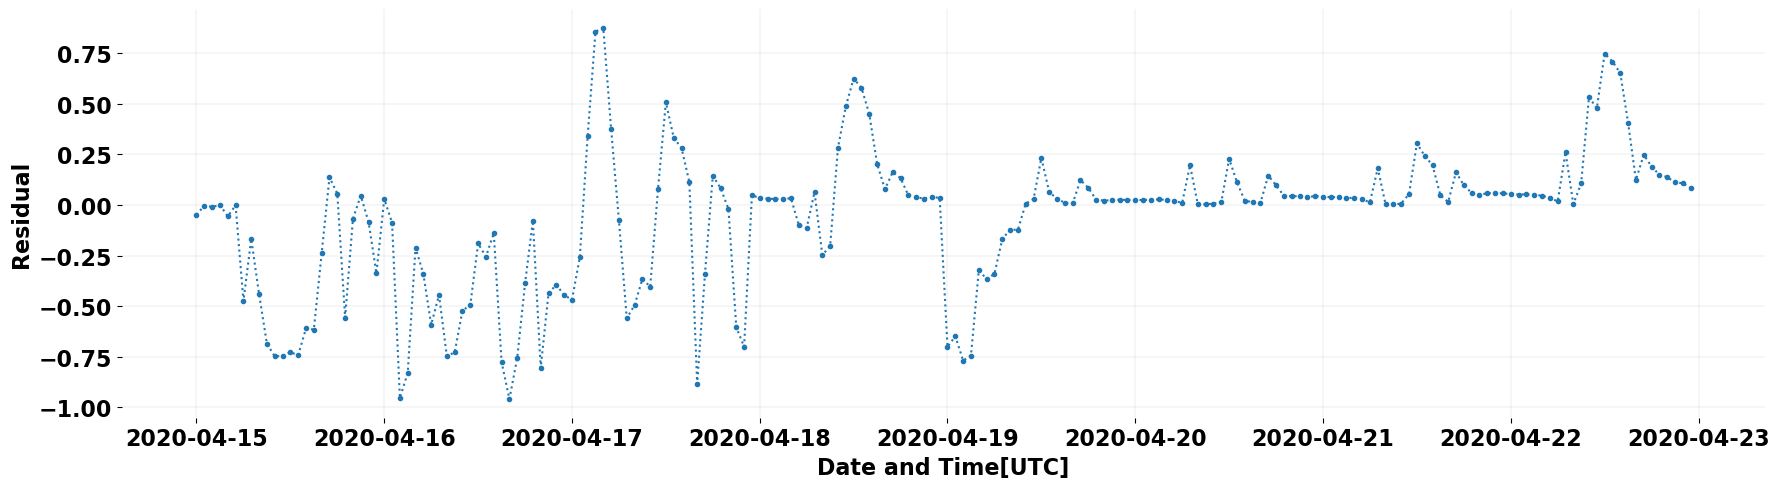

In [130]:
plt.figure(figsize = (18,5))
plt.plot(df_IR_hourly['DateTime'], err_ir_dwd,'.:')
# plt.plot(df_IR_hourly_day['DateTime'], err_ir_dwd_day,'.:')
# plt.plot(df_IR_hourly_night['DateTime'], err_ir_dwd_night,'.:')
plt.xticks(fontweight = 'bold',size = 16)
plt.yticks(fontweight = 'bold',size = 16)
plt.grid(color = 'gray', linewidth = 0.1)
plt.xlabel('Date and Time[UTC]',fontweight = 'bold', size = 16)
plt.ylabel('Residual',fontweight = 'bold', size = 16)
# plt.title('')
plt.tight_layout()
plt.box()
plt.show()
# plt.show()

In [131]:
range_1 = len(err_ir_dwd_night[(err_ir_dwd_night >=-0.1) & (err_ir_dwd_night <=0.1) ])/len(err_ir_dwd_night)*100
print('-0.1 - 0.1 :',range_1)
range_2 = len(err_ir_dwd_night[(err_ir_dwd_night >=-0.2) & (err_ir_dwd_night <=0.2) ])/len(err_ir_dwd_night)*100
print('-0.2 - 0.2 :',range_2)
range_3 = len(err_ir_dwd_night[(err_ir_dwd_night >=-0.3) & (err_ir_dwd_night <=0.3) ])/len(err_ir_dwd_night)*100
print('-0.3 - 0.3 :',range_3)
print('Median:',np.median(err_ir_dwd_night))
print('5th Percentile:',np.percentile(err_ir_dwd_night,5))
print('95th Percentile:',np.percentile(err_ir_dwd_night,95))

-0.1 - 0.1 : 61.111111111111114
-0.2 - 0.2 : 65.27777777777779
-0.3 - 0.3 : 66.66666666666666
Median: 0.0031417978689567373
5th Percentile: -0.9530069278784987
95th Percentile: 0.008719455709287536


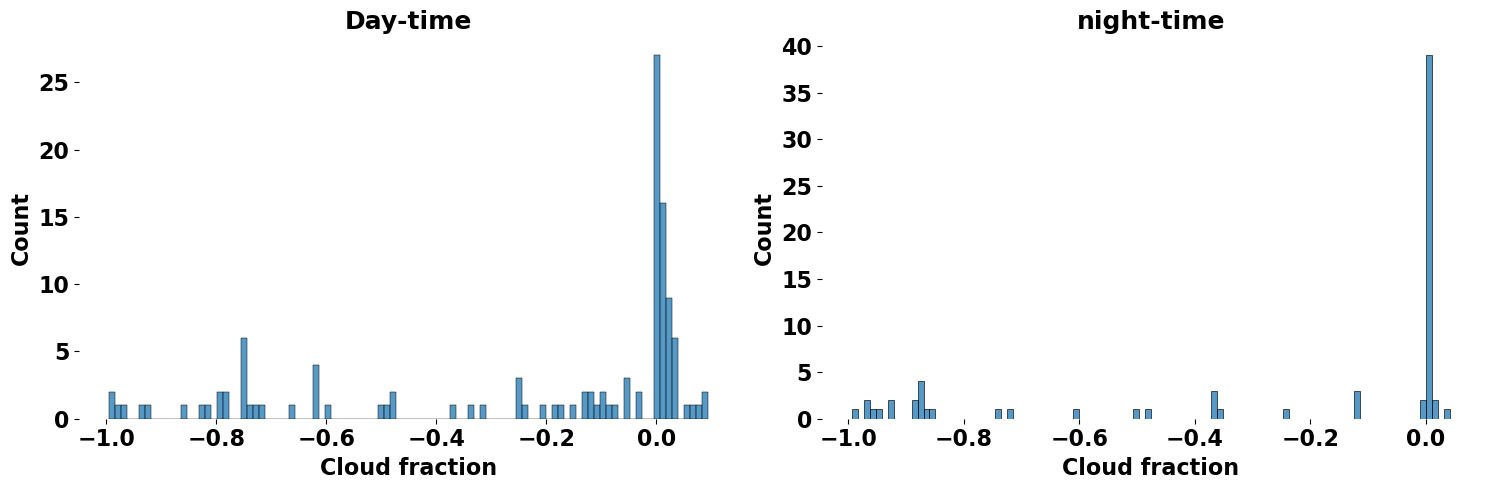

In [132]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
sns.histplot(err_ir_dwd_day, bins = 100)
plt.title('Day-time', fontweight = 'bold',size = 18)
plt.xlabel('Cloud fraction',fontweight = 'bold',size = 16)
plt.ylabel('Count',fontweight = 'bold',size = 16)
plt.xticks(fontweight = 'bold',size = 16)
plt.yticks(fontweight = 'bold',size = 16)
plt.box()
plt.tight_layout()
# plt.show()

plt.subplot(1,2,2)
sns.histplot(err_ir_dwd_night, bins = 100)
plt.title('night-time', fontweight = 'bold',size = 18)
plt.xlabel('Cloud fraction',fontweight = 'bold',size = 16)
plt.ylabel('Count',fontweight = 'bold',size = 16)
plt.xticks(fontweight = 'bold',size = 16)
plt.yticks(fontweight = 'bold',size = 16)
plt.box()
plt.tight_layout()

plt.show()

#### Allsky vs DWD

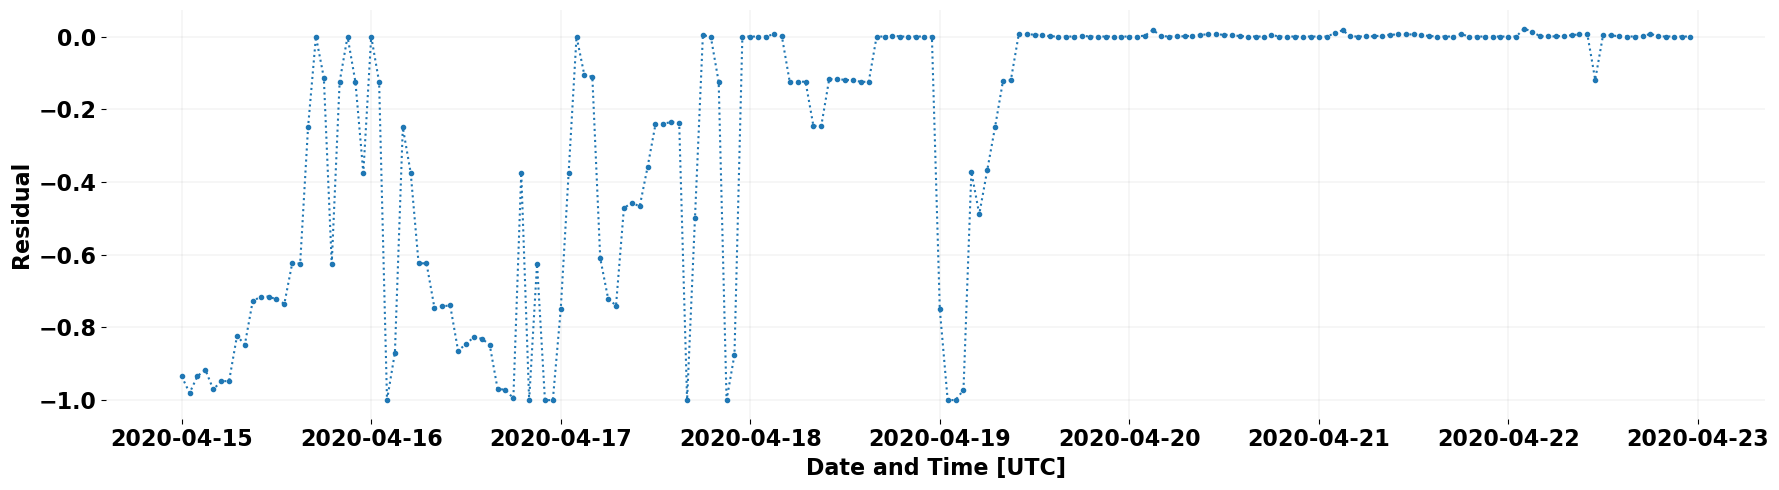

In [135]:
residual = df_color_hourly['cloud_fraction'].values/8 - df_weather['cloud'].values/8
# df_color_hourly

plt.figure(figsize = (18,5))
plt.plot(df_color_hourly['DateTime'], residual,'.:')
# plt.plot(df_IR_hourly_day['DateTime'], err_ir_dwd_day,'.:')
# plt.plot(df_IR_hourly_night['DateTime'], err_ir_dwd_night,'.:')
plt.xticks(fontweight = 'bold',size = 16)
plt.yticks(fontweight = 'bold',size = 16)
plt.grid(color = 'gray', linewidth = 0.1)
plt.xlabel('Date and Time [UTC]',fontweight = 'bold', size = 16)
plt.ylabel('Residual',fontweight = 'bold', size = 16)
# plt.title('')
plt.tight_layout()
plt.box()
plt.show()

In [136]:
df_color_hourly_day = df_color_hourly[(df_color_hourly.hour >= 6 ) & (df_color_hourly.hour <= 20 )]
df_weather_day = df_weather[(df_weather.hour >= 6 ) & (df_weather.hour <= 20 )]
# df_weather_day

err_color_dwd_day = df_color_hourly_day['cloud_fraction'].values/8 - df_weather_day['cloud'].values/8

In [137]:
df_color_hourly_night = df_color_hourly[(df_color_hourly.hour < 6 ) | (df_color_hourly.hour > 20 )]
df_weather_night = df_weather[(df_weather.hour < 6 ) | (df_weather.hour > 20 )]
# df_weather_day

err_color_dwd_night = df_color_hourly_night['cloud_fraction'].values/8 - df_weather_night['cloud'].values/8

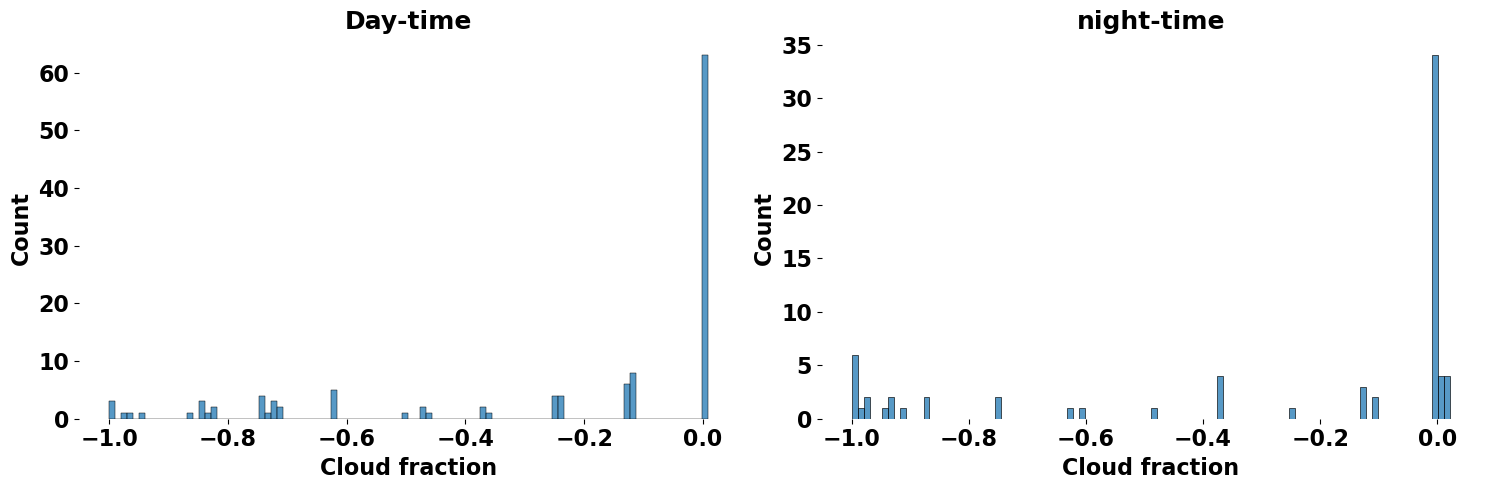

In [138]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
sns.histplot(err_color_dwd_day, bins = 100)
plt.title('Day-time', fontweight = 'bold', size = 18)
plt.xlabel('Cloud fraction',fontweight = 'bold', size = 16 )
plt.ylabel('Count',fontweight = 'bold', size = 16)
plt.xticks(fontweight = 'bold', size = 16)
plt.yticks(fontweight = 'bold', size = 16)
plt.box()
plt.tight_layout()
# plt.show()

plt.subplot(1,2,2)
sns.histplot(err_color_dwd_night, bins = 100)
plt.title('night-time', fontweight = 'bold', size = 18)
plt.xlabel('Cloud fraction',fontweight = 'bold', size = 16)
plt.ylabel('Count',fontweight = 'bold', size = 16)
plt.xticks(fontweight = 'bold', size = 16)
plt.yticks(fontweight = 'bold', size = 16)
plt.box()
plt.tight_layout()

plt.show()

In [127]:
range_1 = len(err_color_dwd_day[(err_color_dwd_day >=-0.1) & (err_color_dwd_day <=0.1) ])/len(err_color_dwd_day)*100
print('-0.1 - 0.1 :',range_1)
range_2 = len(err_color_dwd_day[(err_color_dwd_day >=-0.2) & (err_color_dwd_day <=0.2) ])/len(err_color_dwd_day)*100
print('-0.2 - 0.2 :',range_2)
range_3 = len(err_color_dwd_day[(err_color_dwd_day >=-0.3) & (err_color_dwd_day <=0.3) ])/len(err_color_dwd_day)*100
print('-0.3 - 0.3 :',range_3)
print('Median:',np.median(err_color_dwd_day))
print('5th Percentile:',np.percentile(err_color_dwd_day,5))
print('95th Percentile:',np.percentile(err_color_dwd_day,95))

-0.1 - 0.1 : 52.5
-0.2 - 0.2 : 64.16666666666667
-0.3 - 0.3 : 70.83333333333334
Median: 2.129445507876294e-06
5th Percentile: -0.8683185033585872
95th Percentile: 0.00601597393868435


In [128]:
range_1 = len(err_color_dwd_night[(err_color_dwd_night >=-0.1) & (err_color_dwd_night <=0.1) ])/len(err_color_dwd_night)*100
print('-0.1 - 0.1 :',range_1)
range_2 = len(err_color_dwd_night[(err_color_dwd_night >=-0.2) & (err_color_dwd_night <=0.2) ])/len(err_color_dwd_night)*100
print('-0.2 - 0.2 :',range_2)
range_3 = len(err_color_dwd_night[(err_color_dwd_night >=-0.3) & (err_color_dwd_night <=0.3) ])/len(err_color_dwd_night)*100
print('-0.3 - 0.3 :',range_3)
print('Median:',np.median(err_color_dwd_night))
print('5th Percentile:',np.percentile(err_color_dwd_night,5))
print('95th Percentile:',np.percentile(err_color_dwd_night,95))

-0.1 - 0.1 : 58.333333333333336
-0.2 - 0.2 : 65.27777777777779
-0.3 - 0.3 : 66.66666666666666
Median: 3.314709292285625e-05
5th Percentile: -0.9999520831791608
95th Percentile: 0.010805736451318493


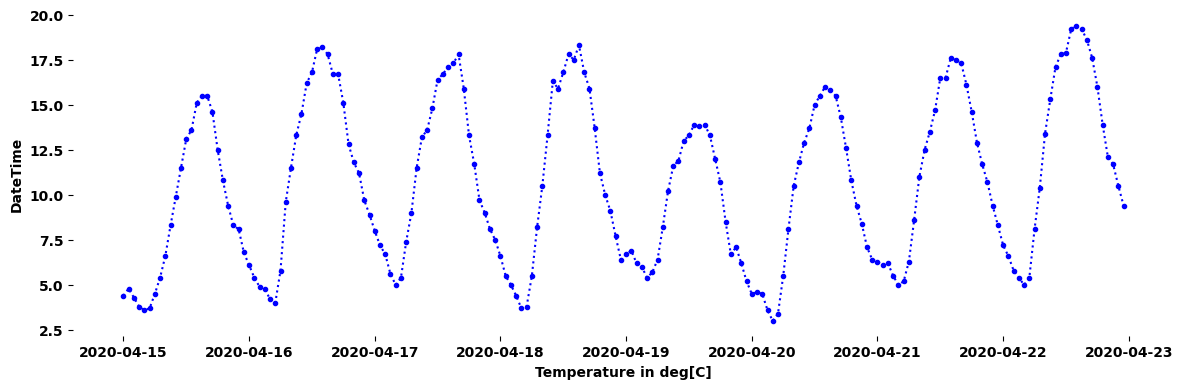

In [129]:
plt.figure(figsize = (12,4))

plt.plot(df_weather['DateTime'],df_weather['Amb_Tem'],'b.:')
# plt.title('Hourly Ambient Temperature', fontweight = 'bold')
plt.xlabel('Temperature in deg[C]',fontweight = 'bold')
plt.ylabel('DateTime',fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.box()
plt.tight_layout()

plt.show()

In [140]:
def image_grid(image,dist,az_step,vza,vza_step,center):
    rotation = np.arange(0,360,360/az_step)
    arr = np.empty((1,2))
    for j in range(center[1],center[1]+dist):
        a = [j]
        b = np.vstack((center[0],a)).T
        arr = np.append(arr,b,axis = 0)
    
    inp = arr[1:,:]
    
    pxl = np.empty((1,2))
    
    for j in rotation:
        vec = [inp[-1][0] - center[0], center[1]- inp[-1][1]]
        p1 = np.around(rot(vec,j))
        p_1 = np.vstack((p1[0] + center[0] , center[1] - p1[1] )).T
        pxl = np.append(pxl ,p_1,axis = 0)
        
    grid = pxl[1:]   
    cir = np.arange(0,dist,dist/vza_step)
    font = cv.FONT_ITALIC 
    
    grid = pxl[1:]
# print(grid)
    for i in cir:
    #         print(i)
        cv.circle(image,(center[0],center[1]),int(i),70)
        for j in range(0,len(inp[0::int(dist/vza_step)])):
            cv.putText(image,str(int(vza[0::int(dist/vza_step)][j])), \
                       (int(inp[0::int(dist/vza_step)][j,0]),\
                        int(inp[0::int(dist/vza_step)][j,1])), font,\
                        0.5, (40), 2, cv.LINE_AA)

        for j in range(0,len(grid)):
            cv.line(image,(center[0],center[1]),(int(grid[j,0]),int(grid[j,1])),70,1)
            cv.putText(image,str(int(rotation[j])), (int(grid[j,0]),int(grid[j,1])), font,\
                                    0.5, (12), 1, cv.LINE_AA)
    return image
df_blank = pd.read_csv('DWD_code_data/blank_image_data.csv')
def image_mask(mod,fillna):
    mask = pd.read_csv('contour_new.csv')
    Z_mod = mod.reshape(-1,1)
    img_df = pd.DataFrame({'pxl_img':Z_mod[:,0]})
    img_mod = pd.DataFrame({'pxl_img_mod':Z_mod[:,0]})
    # df_0 = pd.dataFrame({'pxl:', })
    df_0 = pd.DataFrame(0, index=range(len(df_blank)), columns={'f_pxl_1'})

    masking_mod= pd.merge(img_mod,mask,on = img_df.index)

    # merged = pd.merge(df_blank, img_df,on = img_df.index)
    
    df_mod_int = masking_mod[masking_mod['contour']< 255]
    dataset_plot_mod = pd.merge(df_mod_int, df_0, how='outer', on=None, \
                                left_index=True, right_index=True, sort=True) 
    # dataset_plot.head()
    df_masked_mod = dataset_plot_mod[['key_0', 'pxl_img_mod','contour']].fillna(fillna)  
    image = np.uint8(df_masked_mod['pxl_img_mod'].values.reshape(480,640))
    return image

263.88823529411764


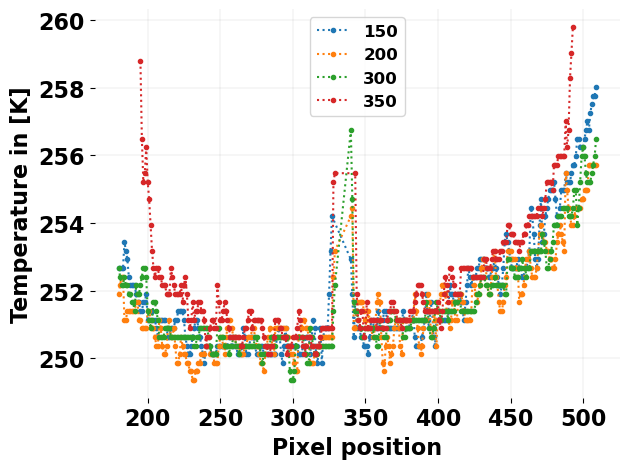

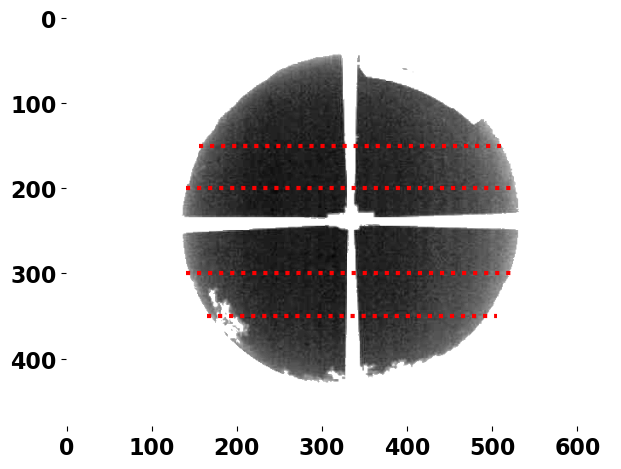

In [176]:
# img = image_mask(cv.imread('April2020_Images/Images22_04/20200422_130106_-10+25_IrImage.jpg',0),255)
img = image_mask(cv.imread('April2020_Images/Images22_04/20200422_000001_-10+25_IrImage.jpg',0),120)
# img = image_mask(cv.imread('April2020_Images/Images22_04/20200422_091836_-10+25_IrImage.jpg',0),255)


Tmin = -40+273.3
Tmax = 25+273.3
Zmax = 255 
Zmin = 0
c = Tmin

m = (Tmax - Tmin) / (Zmax - Zmin)
print(m*120 + c)
k = [150,200,300,350]
y = np.arange(180,510,1)
for k in k:
    Z = img[k,180:510]
    T = m*Z + c

    stack = np.vstack((y,T)).T
#     print(stack)
    plt.plot(stack[stack[:,1] < 263.88][:,0],stack[stack[:,1] < 263.88][:,1],'.:',label = k)
    plt.legend(loc = 'best',prop={'size':12,'weight':'bold'})
    plt.xticks(fontweight = 'bold', size = 16)
    plt.yticks(fontweight = 'bold', size = 16)
    plt.ylabel('Temperature in [K]', fontweight = 'bold', size = 16)
    plt.xlabel('Pixel position', fontweight = 'bold', size = 16)
    
plt.tight_layout()
plt.box()
plt.grid(color = 'gray', linewidth = 0.1)
plt.show()

plt.imshow(img,cmap = 'gray')
plt.xticks(fontweight = 'bold', size = 16)
plt.yticks(fontweight = 'bold', size = 16)
plt.plot([155,510], [150,150],'r:', linewidth = 3)
plt.plot([140,528], [200,200],'r:', linewidth = 3)
plt.plot([165,505], [350,350],'r:', linewidth = 3)
plt.plot([140,528], [300,300],'r:', linewidth = 3)
plt.tight_layout()
plt.box()
plt.show()

In [5]:
df_al = pd.read_csv('mirror_properties/emissivity_al.csv',header =None).\
        rename(columns={0: "theta", 1: "Transmittance",2:'Reflectance',3:'emittance'})

df_pol = pd.read_csv('mirror_properties/emissivity_pol.csv',header =None).\
            rename(columns={0: "theta", 1: "Transmittance",2:'Reflectance',3:'emittance'})

df_pet = pd.read_csv('mirror_properties/emissivity_pet.csv',header =None).\
            rename(columns={0: "theta", 1: "Transmittance",2:'Reflectance',3:'emittance'})

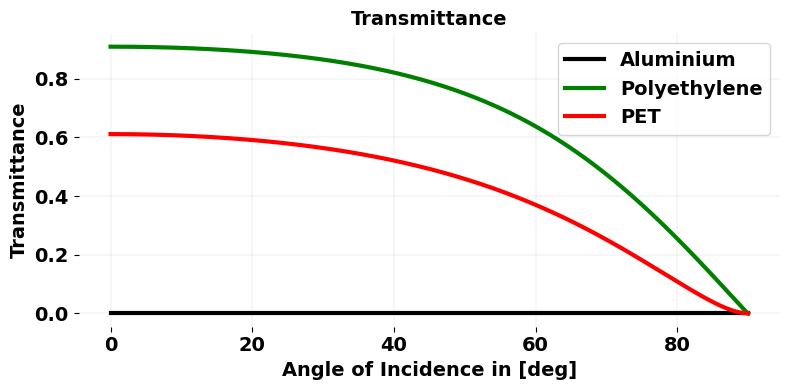

In [23]:
plt.figure(figsize = (8,4))

plt.plot(df_al['theta'],df_al['Transmittance'],'k',linewidth = 3,label = 'Aluminium')
plt.plot(df_pol['theta'],df_pol['Transmittance'],'g',linewidth = 3,label = 'Polyethylene')
plt.plot(df_pet['theta'],df_pet['Transmittance'],'r',linewidth = 3,label = 'PET')

plt.legend(loc = 'best',prop={'size':14,'weight':'bold'})
plt.grid(color = 'gray',linewidth = 0.1)
plt.xticks(size = 14,fontweight = 'bold')
plt.yticks(size = 14,fontweight = 'bold')
plt.xlabel('Angle of Incidence in [deg]',size = 14,fontweight = 'bold')
plt.ylabel('Transmittance',size = 14,fontweight = 'bold')
plt.title('Transmittance',size = 14,fontweight = 'bold')
plt.box()
plt.tight_layout()
plt.show()

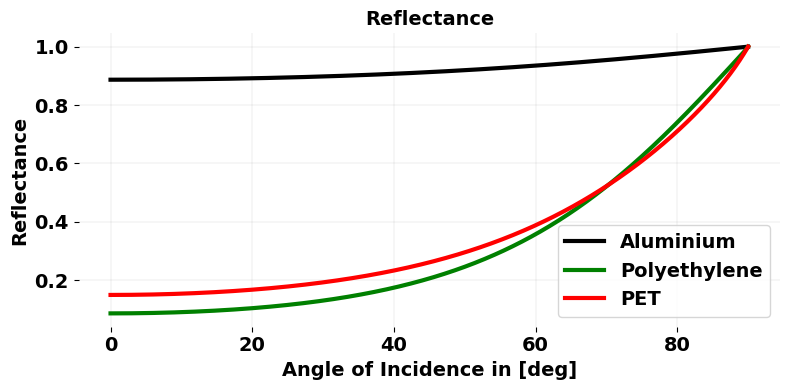

In [24]:
plt.figure(figsize = (8,4))

plt.plot(df_al['theta'],df_al['Reflectance'],'k',linewidth = 3,label = 'Aluminium')
plt.plot(df_pol['theta'],df_pol['Reflectance'],'g',linewidth = 3,label = 'Polyethylene')
plt.plot(df_pet['theta'],df_pet['Reflectance'],'r',linewidth = 3,label = 'PET')

plt.legend(loc = 'best',prop={'size':14,'weight':'bold'})
plt.grid(color = 'gray',linewidth = 0.1)
plt.xticks(size = 14,fontweight = 'bold')
plt.yticks(size = 14,fontweight = 'bold')
plt.xlabel('Angle of Incidence in [deg]',size = 14,fontweight = 'bold')
plt.ylabel('Reflectance',size = 14,fontweight = 'bold')
plt.title('Reflectance',size = 14,fontweight = 'bold')
plt.box()
plt.tight_layout()
plt.show()

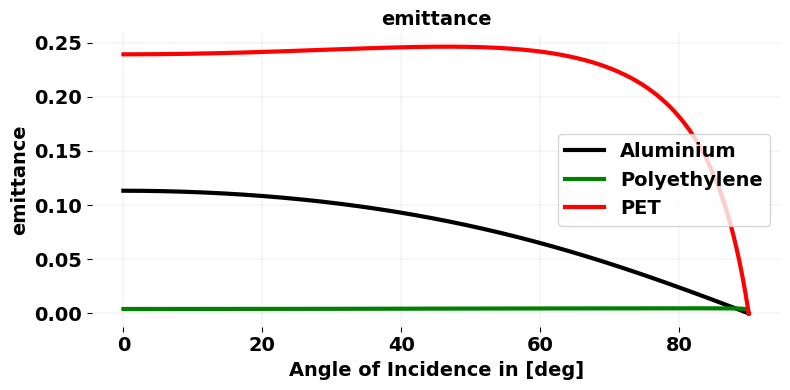

In [25]:
plt.figure(figsize = (8,4))

plt.plot(df_al['theta'],df_al['emittance'],'k',linewidth = 3,label = 'Aluminium')
plt.plot(df_pol['theta'],df_pol['emittance'],'g',linewidth = 3,label = 'Polyethylene')
plt.plot(df_pet['theta'],df_pet['emittance'],'r',linewidth = 3,label = 'PET')

plt.legend(loc = 'best',prop={'size':14,'weight':'bold'})
plt.grid(color = 'gray',linewidth = 0.1)
plt.xticks(size = 14,fontweight = 'bold')
plt.yticks(size = 14,fontweight = 'bold')
plt.xlabel('Angle of Incidence in [deg]',size = 14,fontweight = 'bold')
plt.ylabel('emittance',size = 14,fontweight = 'bold')
plt.title('emittance',size = 14,fontweight = 'bold')
plt.box()
plt.tight_layout()
plt.show()

In [39]:
print(df_DWD.info())
df_DWD_target = df_DWD[(df_DWD.DateTime > '2020-04-14 23:00:00') & (df_DWD.DateTime < '2020-04-23 00:00:00')]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  5434 non-null   datetime64[ns]
 1   CWV       5434 non-null   float64       
 2   dwd_vis   5434 non-null   float64       
 3   Vis       5434 non-null   float64       
 4   AOD       5434 non-null   float64       
 5   Amb_Tem   5434 non-null   float64       
 6   Dew_Tem   5434 non-null   float64       
 7   cloud     5434 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 339.8 KB
None


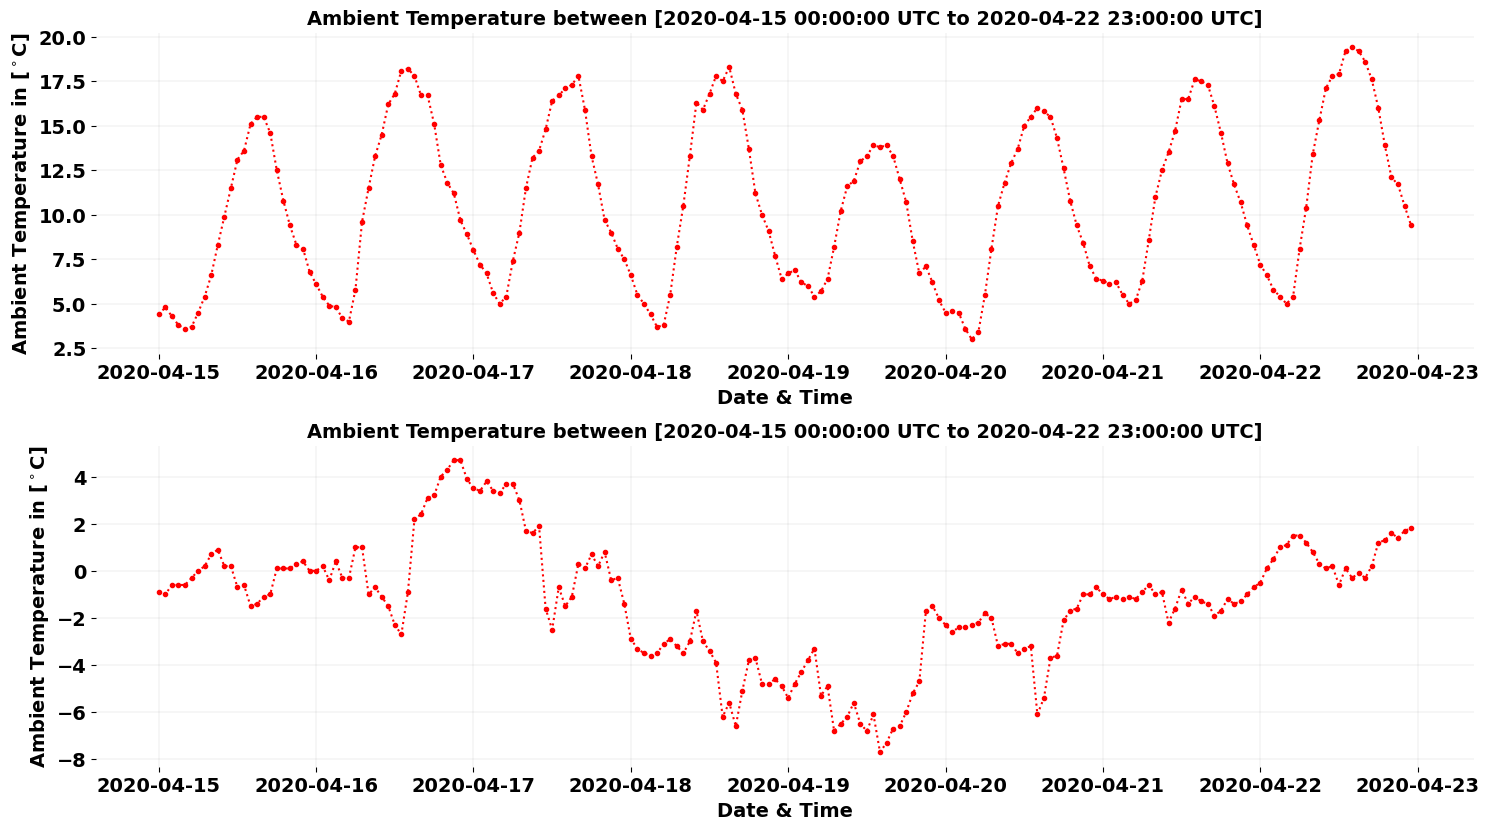

In [50]:
fig = plt.figure(figsize = (15,12))

plt.subplot(3,1,1)
plt.plot(df_DWD_target['DateTime'],df_DWD_target['Amb_Tem'],'r:.',label = 'PET')

# plt.legend(loc = 'best',prop={'size':14,'weight':'bold'})
plt.grid(color = 'gray',linewidth = 0.1)
plt.xticks(size = 14,fontweight = 'bold')
plt.yticks(size = 14,fontweight = 'bold')
plt.xlabel('Date & Time',size = 14,fontweight = 'bold')
plt.ylabel('Ambient Temperature in [$^\circ$C]',size = 14,fontweight = 'bold')
plt.title('Ambient Temperature between [2020-04-15 00:00:00 UTC to 2020-04-22 23:00:00 UTC]',size = 14,fontweight = 'bold')
plt.box()
plt.tight_layout()
# plt.show()

# plt.subplot(3,1,2)
# plt.plot(df_DWD_target['DateTime'],df_DWD_target['dwd_vis'],'r:.',label = 'PET')

# # plt.legend(loc = 'best',prop={'size':14,'weight':'bold'})
# plt.grid(color = 'gray',linewidth = 0.1)
# plt.xticks(size = 14,fontweight = 'bold')
# plt.yticks(size = 14,fontweight = 'bold')
# plt.xlabel('Date & Time',size = 14,fontweight = 'bold')
# plt.ylabel('Ambient Temperature in [$^\circ$C]',size = 14,fontweight = 'bold')
# plt.title('Ambient Temperature between [2020-04-15 00:00:00 UTC to 2020-04-22 23:00:00 UTC]',size = 14,fontweight = 'bold')
# plt.box()
# plt.tight_layout()


plt.subplot(3,1,2)
plt.plot(df_DWD_target['DateTime'],df_DWD_target['Dew_Tem'],'r:.',label = 'PET')

# plt.legend(loc = 'best',prop={'size':14,'weight':'bold'})
plt.grid(color = 'gray',linewidth = 0.1)
plt.xticks(size = 14,fontweight = 'bold')
plt.yticks(size = 14,fontweight = 'bold')
plt.xlabel('Date & Time',size = 14,fontweight = 'bold')
plt.ylabel('Ambient Temperature in [$^\circ$C]',size = 14,fontweight = 'bold')
plt.title('Ambient Temperature between [2020-04-15 00:00:00 UTC to 2020-04-22 23:00:00 UTC]',size = 14,fontweight = 'bold')
plt.box()
plt.tight_layout()
plt.show()

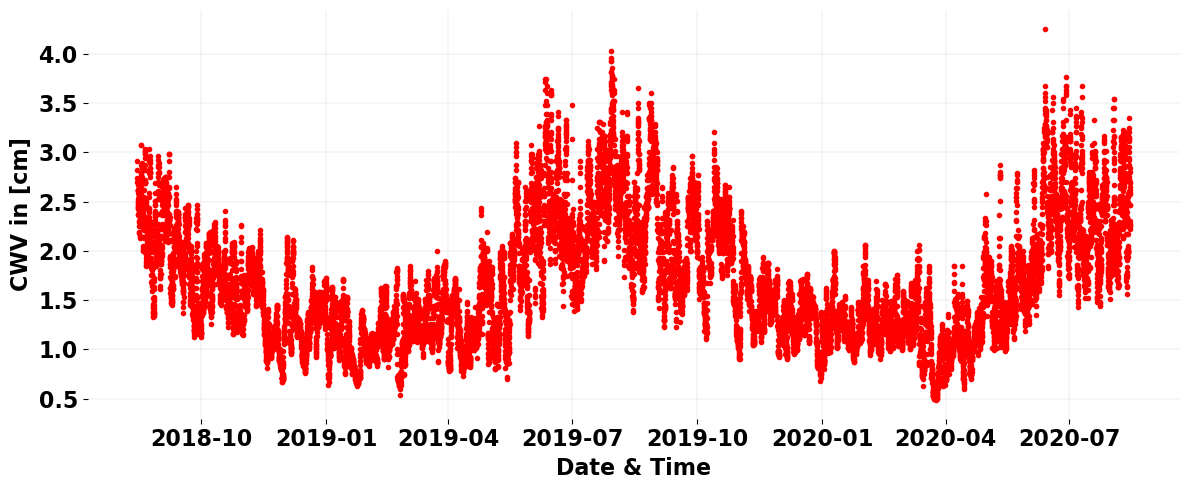

In [63]:
plt.figure(figsize = (12,5))
plt.plot(df_DWD['DateTime'], df_DWD['CWV'],'.r')

plt.grid(color = 'gray',linewidth = 0.1)
plt.xticks(size = 16,fontweight = 'bold')
plt.yticks(size = 16,fontweight = 'bold')
plt.xlabel('Date & Time',size = 16,fontweight = 'bold')
plt.ylabel('CWV in [cm]',size = 16,fontweight = 'bold')
# plt.title('Date and Time in [UTC]',size = 14,fontweight = 'bold')
plt.box()
plt.tight_layout()
plt.show()

In [65]:
import cv2 as cv

ir = cv.imread('April2020_Images/Images17_04/20200417_060001_-10+25_IrImage.jpg')
color = cv.flip(cv.flip(cv.imread('April2020_colorimages/Images17_04/20200417_050003_stack.jpg'),0),-1)

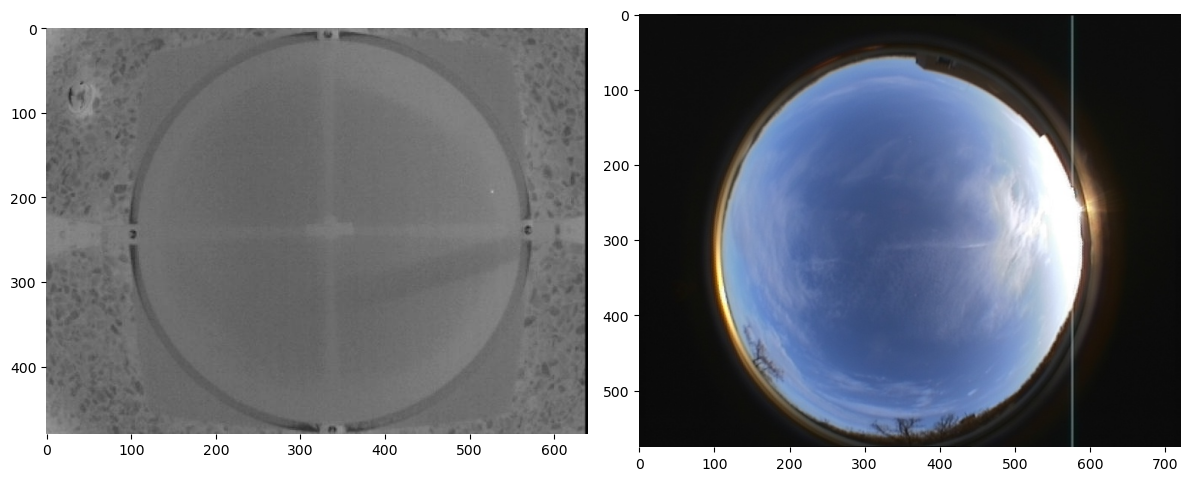

In [70]:
fig = plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.imshow(ir[:,:,::-1])
plt.box()
plt.tight_layout()
# plt.show()

plt.subplot(1,2,2)
plt.imshow(color[:,:,::-1])
plt.box()
plt.tight_layout()
plt.show()